In [1]:
library("Matrix")

In [2]:
library("SCENIC")

Warning message:
“multiple methods tables found for ‘which’”
Warning message:
“multiple methods tables found for ‘which’”


In [3]:
library("Seurat")

Attaching SeuratObject



In [4]:
library("RcisTarget")

In [5]:
library("doParallel")

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [6]:
library("SCopeLoomR")


Attaching package: ‘SCopeLoomR’


The following object is masked from ‘package:base’:

    flush




In [7]:
library(cowplot)

In [8]:
dir.create("SCENIC_0727_AL")
setwd("SCENIC_0727_AL") 

Warning message in dir.create("SCENIC_0727_AL"):
“'SCENIC_0727_AL' already exists”


In [9]:
load(file="../0711-ob.integratve-7samples.Rda")

In [10]:
allPC3merge<-ob.integrated

In [11]:
allPC3merge@meta.data$orig.ident<-gsub('1','',allPC3merge@meta.data$orig.ident)

In [12]:
allPC3merge@meta.data$orig.ident<-gsub('2','',allPC3merge@meta.data$orig.ident)

In [13]:
allPC3merge@meta.data$orig.ident<-gsub('3','',allPC3merge@meta.data$orig.ident)

In [14]:
allPC3merge@meta.data$orig.ident<-gsub('public','normal',allPC3merge@meta.data$orig.ident)

In [15]:
table(allPC3merge@meta.data$orig.ident)


  MGUSPC normalPC    pALPC 
    3339     1071     9671 

In [16]:
allPC3<-subset(allPC3merge,orig.ident=='pALPC')

In [17]:
allPC3

An object of class Seurat 
22868 features across 9671 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [18]:
exprMat<-GetAssayData(allPC3,slot="data")
exprMat<-as.matrix(exprMat)
exprMat_log <- log2(exprMat+1)

Warning message in eval(expr, envir, enclos):
“NaNs produced”


In [19]:
exprMat_log[is.na(exprMat_log)]<-0

In [20]:
dir.create("int")

Warning message in dir.create("int"):
“'int' already exists”


In [21]:
cellInfo <- data.frame(seuratCluster=Idents(allPC3))

In [22]:
cellInfo$nGene <- colSums(exprMat>0)
head(cellInfo)

seuratCluster nGene
AAACCTGAGGCCCTCA-1_3 0             1207 
AAACCTGAGTTTGCGT-1_3 2             1176 
AAACCTGGTACGCTGC-1_3 1             1346 
AAACCTGGTGAGTATA-1_3 2             1105 
AAACCTGGTTATCACG-1_3 1             1328 
AAACCTGGTTCCCGAG-1_3 0             1185

In [24]:
cellInfo <- data.frame(cellInfo)
cbind(table(cellInfo$seuratCluster))
saveRDS(cellInfo, file="int/cellInfo.Rds")

[,1]
0 5126
1 1951
2 1126
3  456
4  538
5  385
6   89

In [25]:
scenicOptions <- initializeScenic(org="hgnc", dbDir="/together_sdc/zhoujiaqi/index", nCores=1)
#scenicOptions@inputDatasetInfo$cellInfo <- "int/cellInfo.Rds"
saveRDS(scenicOptions, file="int/scenicOptions.Rds") 

Motif databases selected: 
  hg19-500bp-upstream-7species.mc9nr.feather 
  hg19-tss-centered-10kb-7species.mc9nr.feather

Warning message in RcisTarget::importRankings(dbFilePath, randomCol):
“The following columns are missing from the database: ”
Warning message in RcisTarget::importRankings(dbFilePath, randomCol):
“The following columns are missing from the database: ”


In [26]:
scenicOptions@settings$verbose <- TRUE
scenicOptions@settings$nCores <- 1
scenicOptions@settings$seed <- 123

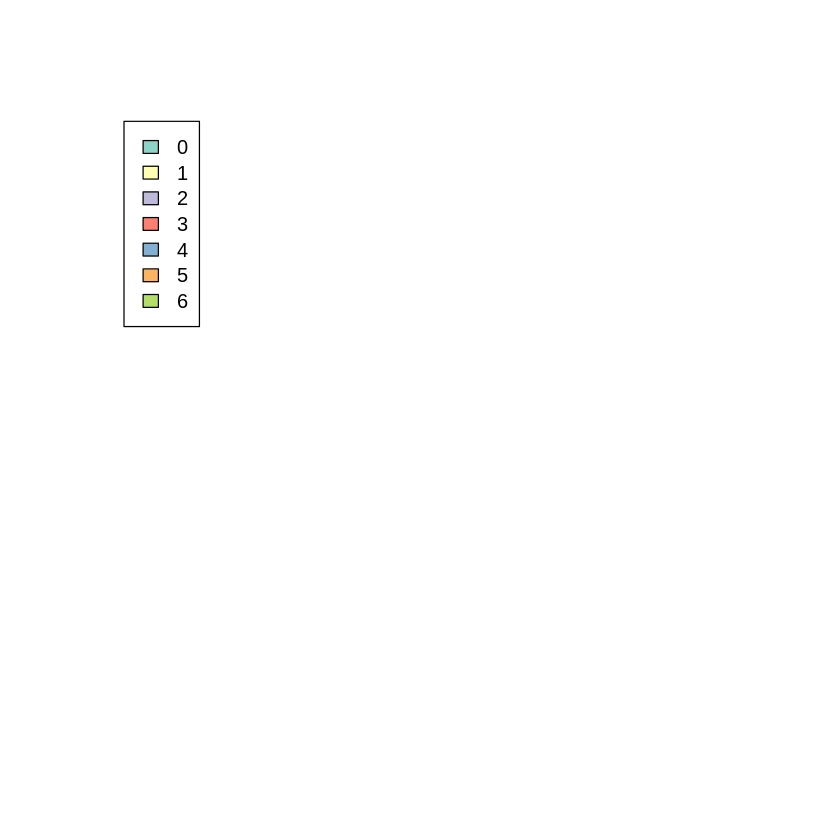

In [28]:
library(RColorBrewer)
colVars <- list(seuratCluster=c("0"=brewer.pal(8,'Set3')[1], 
                           "1"=brewer.pal(8, 'Set3')[2], 
                           "2"=brewer.pal(8,'Set3')[3], 
                           "3"=brewer.pal(8,'Set3')[4], 
                           "4"=brewer.pal(8,'Set3')[5],  
                           "5"=brewer.pal(8,'Set3')[6],
                          "6"=brewer.pal(8,'Set3')[7]))
colVars$seuratCluster <- colVars$seuratCluster[intersect(names(colVars$seuratCluster), cellInfo$seuratCluster)]
plot.new(); legend(0,1, fill=colVars$seuratCluster, legend=names(colVars$seuratCluster))

In [29]:
saveRDS(colVars, file="int/colVars.Rds")

In [30]:
# (Adjust minimum values according to your dataset)
genesKept <- geneFiltering(exprMat, scenicOptions=scenicOptions,
                           minCountsPerGene=3*.01*ncol(exprMat),
                           minSamples=ncol(exprMat)*.01)

Maximum value in the expression matrix: 11.8068979674192

Ratio of detected vs non-detected: 1

Number of counts (in the dataset units) per gene:



    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  -99.80    94.67   282.83  1043.55   764.28 66275.99 


Number of cells in which each gene is detected:



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    925    2842    3476    3735    4239    9671 



Number of genes left after applying the following filters (sequential):

	985	genes with counts per gene > 290.13

	985	genes detected in more than 96.71 cells

	922	genes available in RcisTarget database

Gene list saved in int/1.1_genesKept.Rds



In [31]:
exprMat_filtered <- exprMat[genesKept, ]
dim(exprMat_filtered)

[1]  922 9671

In [32]:
runCorrelation(exprMat_filtered, scenicOptions)

In [33]:
saveRDS(exprMat_filtered,file="exprMat_filtered.Rds")

In [ ]:
# Run GENIE3
runGenie3(exprMat_filtered, scenicOptions)

Using 92 TFs as potential regulators...

Warning message in runGenie3(exprMat_filtered, scenicOptions):
“Only 5% of the 1839 TFs in the database were found in the dataset. Do they use the same gene IDs?
”
Running GENIE3 part 1



In [32]:
scenicOptions <- readRDS("int/scenicOptions.Rds")
scenicOptions@settings$verbose <- TRUE
scenicOptions@settings$nCores <- 1
scenicOptions@settings$seed <- 123

In [33]:
runSCENIC_1_coexNetwork2modules(scenicOptions)

22:26	Creating TF modules



       75%        90% 
0.01192219 0.01483244 


Number of links between TFs and targets: 84732



            [,1]
nTFs          92
nTargets     922
nGeneSets    549
nLinks    233758


In [34]:
scenicOptions <- readRDS("int/scenicOptions.Rds")
scenicOptions@settings$verbose <- TRUE
scenicOptions@settings$nCores <- 1
scenicOptions@settings$seed <- 123

In [35]:
runSCENIC_2_createRegulons(scenicOptions,minGenes = 20)

22:26	Step 2. Identifying regulons

Warning message in RcisTarget::importRankings(dbFilePath, randomCol):
“The following columns are missing from the database: ”
Warning message in RcisTarget::importRankings(dbFilePath, randomCol):
“The following columns are missing from the database: ”
tfModulesSummary:




 top5perTarget top10perTarget          top50 top50perTarget           w001 
            15             31             79             92             92 
          w005 
            92 


22:26	RcisTarget: Calculating AUC

Warning message in importRankings(rnkName, columns = allGenes):
“The following columns are missing from the database: ”
Scoring database:  [Source file: hg19-500bp-upstream-7species.mc9nr.feather]

Warning message in importRankings(rnkName, columns = allGenes):
“The following columns are missing from the database: ”
Scoring database:  [Source file: hg19-tss-centered-10kb-7species.mc9nr.feather]

23:04	RcisTarget: Adding motif annotation

Using BiocParallel...

Using BiocParallel...

Number of motifs in the initial enrichment: 152081

Number of motifs annotated to the matching TF: 6016

23:11	RcisTarget: Prunning targets

Warning message in importRankings(dbNames[motifDbName], columns = allGenes):
“The following columns are missing from the database: ”
Warning message in .addSignificantGenes(resultsTable = resultsTable, geneSets = geneSets, :
“The rakings provided only include a subset of genes/regions included in the whole database.”
Warning message i

[1] "Saving a widget with selfcontained = TRUE requires pandoc. For details see:\nhttps://github.com/rstudio/rmarkdown/blob/master/PANDOC.md"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.0    22.0    56.0   108.3   165.0   482.0 

In [36]:
runSCENIC_3_scoreCells(scenicOptions, exprMat_log)

23:51	Step 3. Analyzing the network activity in each individual cell

	Number of regulons to evaluate on cells: 68
Biggest (non-extended) regulons: 
	 IRF4 (297g)
	 IRF1 (265g)
	 STAT1 (256g)
	 ATF3 (218g)
	 CEBPB (196g)
	 GABPB1 (168g)
	 ARID5B (124g)
	 IRF7 (112g)
	 CEBPG (107g)
	 FOS (97g)

Quantiles for the number of genes detected by cell: 
(Non-detected genes are shuffled at the end of the ranking. Keep it in mind when choosing the threshold for calculating the AUC).



   min     1%     5%    10%    50%   100% 
  15.0   49.0  126.5  196.0 1047.0 1470.0 


Warning message in .AUCell_calcAUC(geneSets = geneSets, rankings = rankings, nCores = nCores, :
“Using only the first 49 genes (aucMaxRank) to calculate the AUC.”
23:57	Finished running AUCell.

23:57	Plotting heatmap...

23:57	Plotting t-SNEs...



png 
  2

In [37]:
runSCENIC_4_aucell_binarize(scenicOptions)

Binary regulon activity: 34 TF regulons x 9671 cells.
(48 regulons including 'extended' versions)
24 regulons are active in more than 1% (96.71) cells.



png 
  2

In [32]:
tsneAUC(scenicOptions, aucType="AUC") 

Warning message:
“executing %dopar% sequentially: no parallel backend registered”


[1] "int/tSNE_AUC_50pcs_50perpl.Rds"

In [33]:
export2scope(scenicOptions, exprMat)

[1] "Adding global attributes..."


Warning message in if (class(dgem) == "dgTMatrix") {:
“the condition has length > 1 and only the first element will be used”


[1] "Adding matrix..."
  |======================================================================| 100%[1] "Adding column attributes..."


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Default metric nUMI was not added because the input matrix does not seem to be the raw counts.”


[1] "Adding default metrics nGene..."
[1] "Adding default embedding..."
[1] "Adding row attributes..."
[1] "Adding columns edges..."
[1] "Adding row edges..."
[1] "Adding layers..."
[1] "Adding embedding SCENIC: tSNE_AUC_50pcs_50perpl.Rds..."


Loom file saved as:	output/scenic.loom



In [34]:
nPcs <- c(5,15,50,100)

In [35]:
scenicOptions <- readRDS("int/scenicOptions.Rds")
scenicOptions@settings$verbose <- TRUE
scenicOptions@settings$nCores <- 1
scenicOptions@settings$seed <- 123

In [36]:
# Run t-SNE with different settings:
fileNames <- tsneAUC(scenicOptions, aucType="AUC", nPcs=nPcs, perpl=nPcs)
fileNames <- tsneAUC(scenicOptions, aucType="AUC", nPcs=nPcs, perpl=nPcs, onlyHighConf=TRUE, filePrefix="int/tSNE_oHC")
# Plot as pdf (individual files in int/):
fileNames <- paste0("int/",grep(".Rds", grep("tSNE_", list.files("int"), value=T), value=T))

In [37]:
options(repr.plot.height=15,repr.plot.width=15)

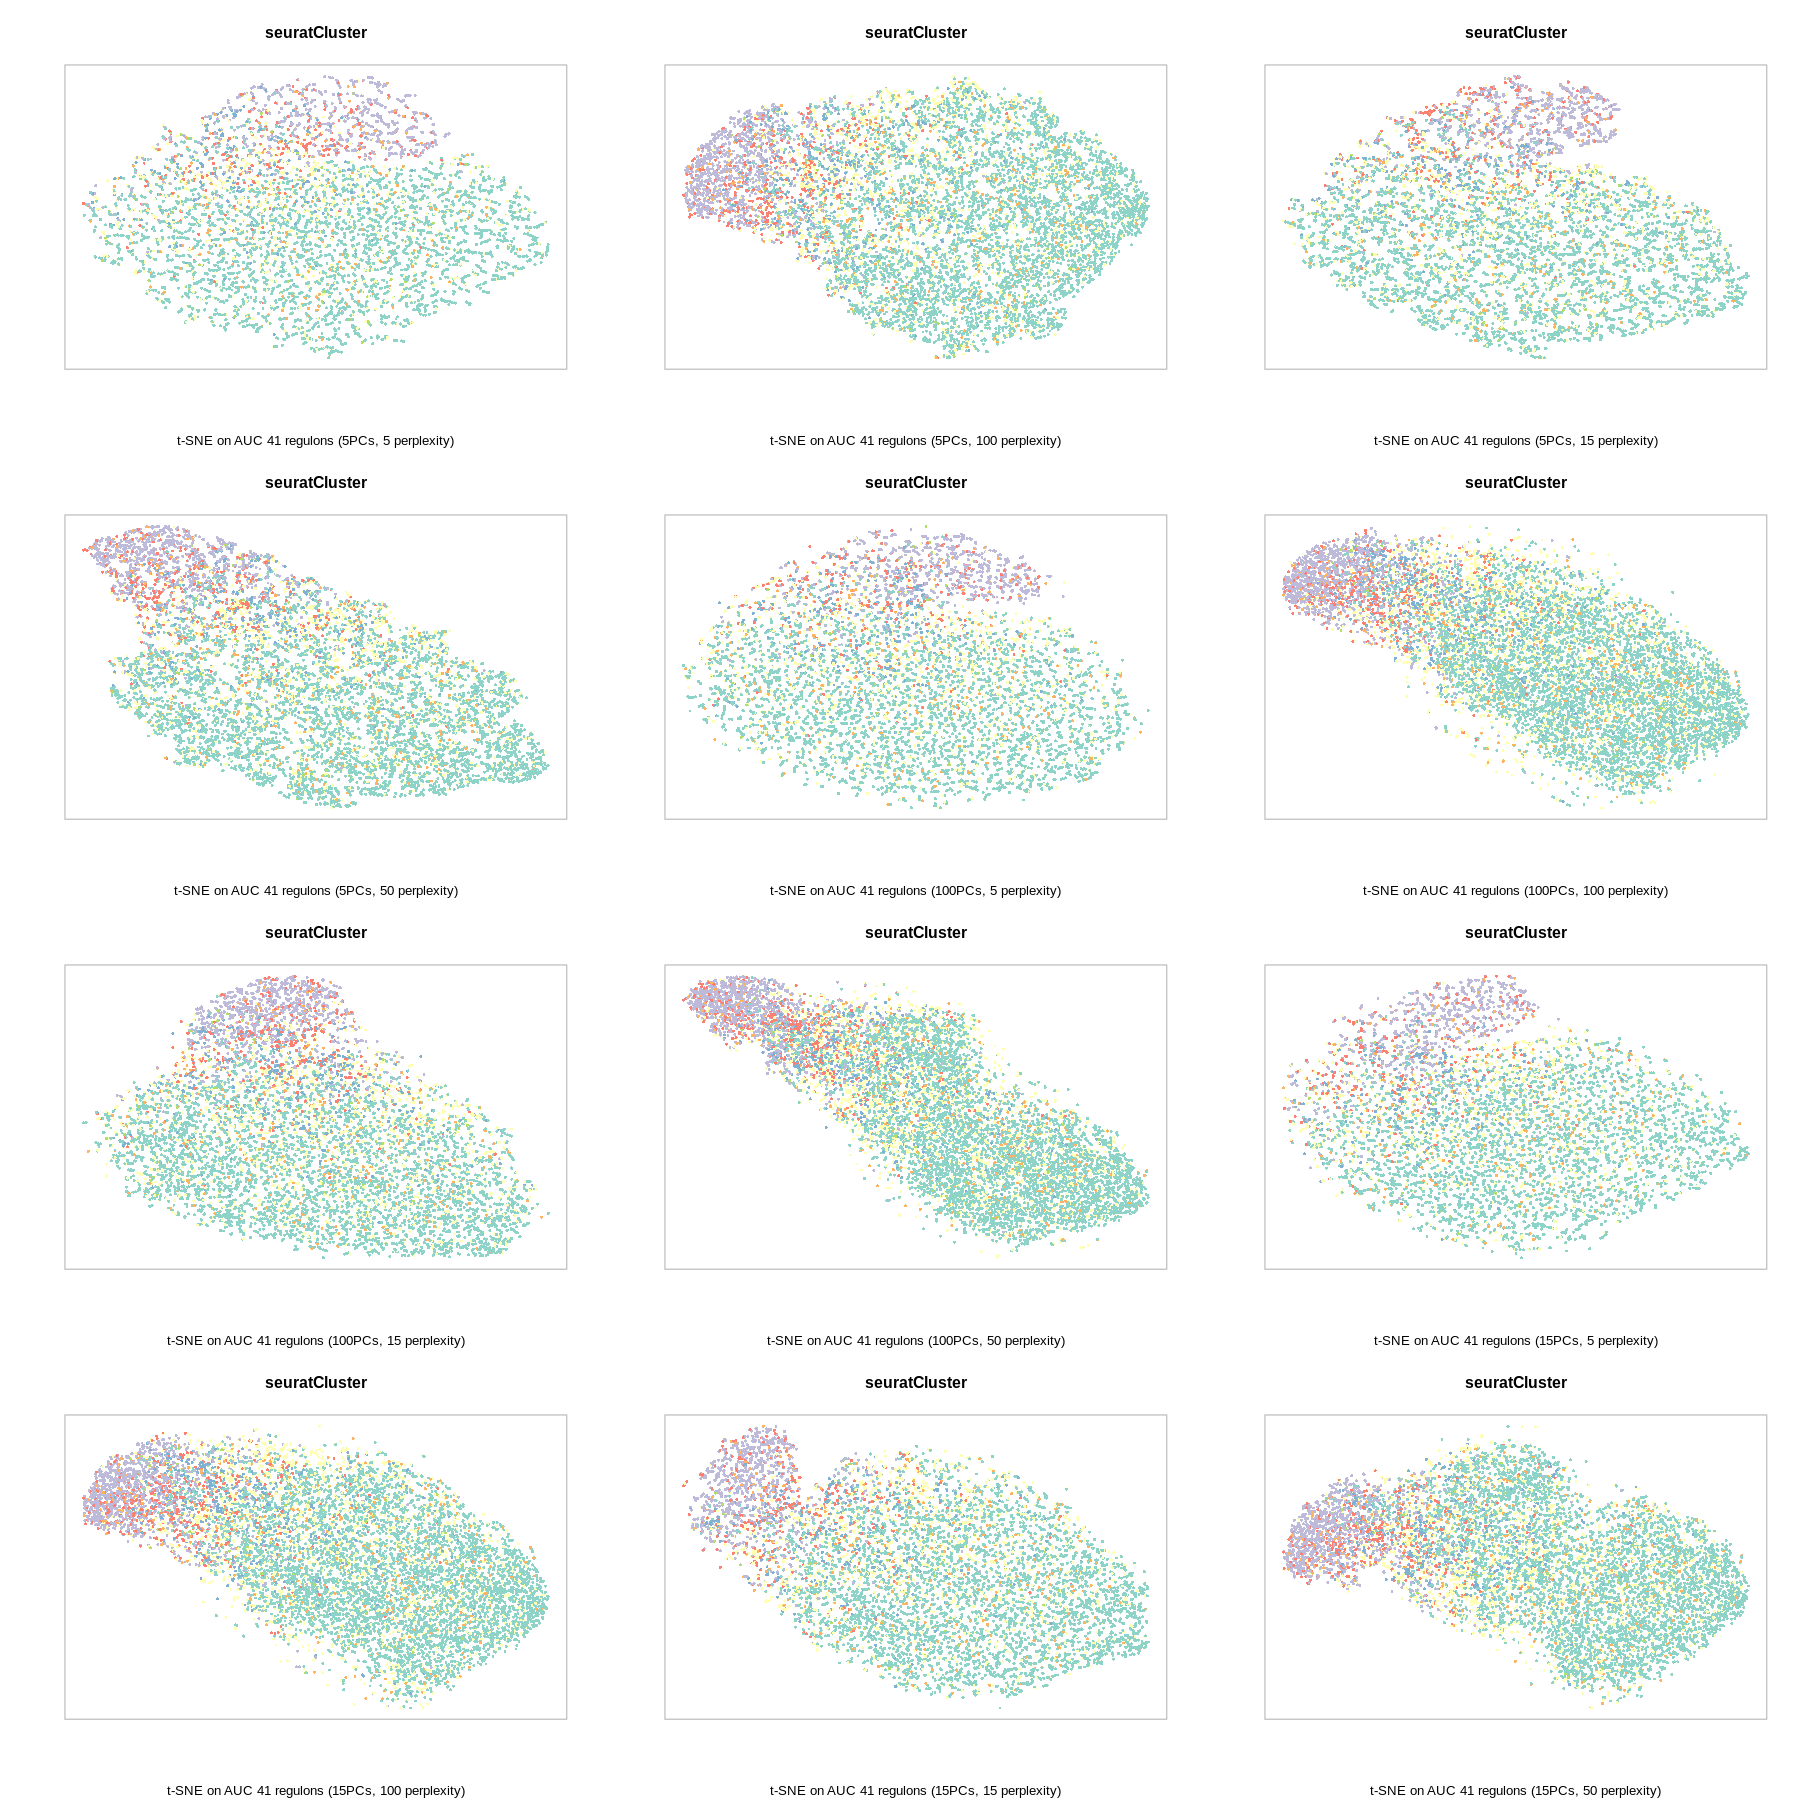

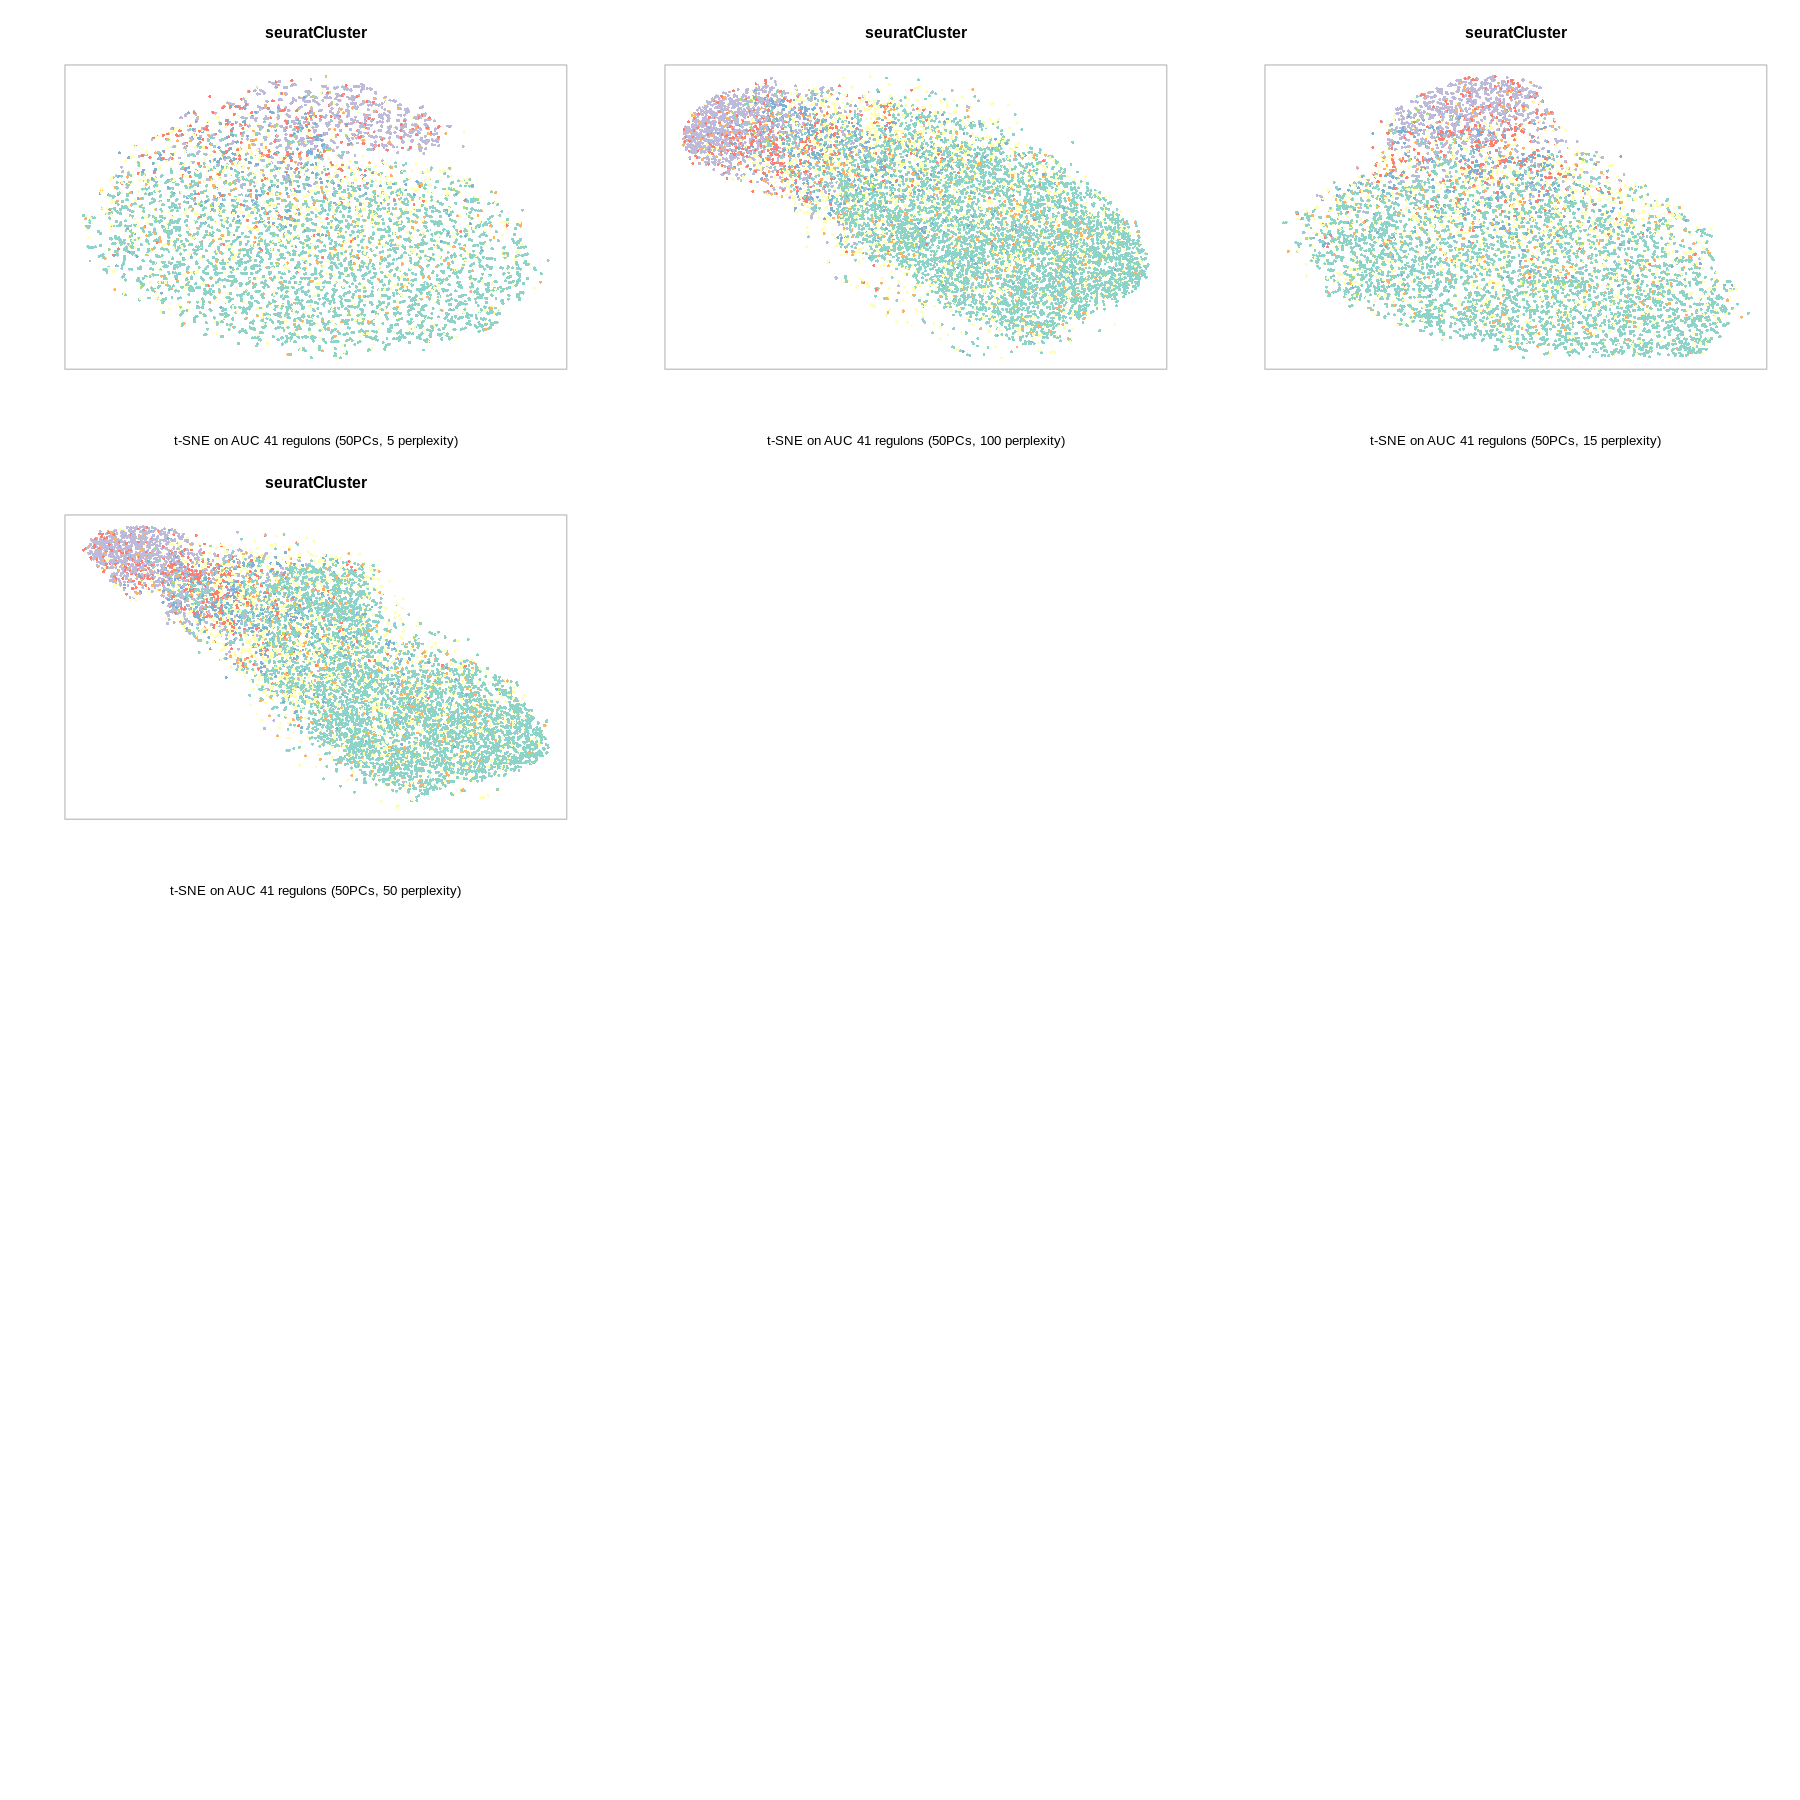

In [38]:
par(mfrow=c(length(nPcs), 3))
fileNames <- paste0("int/",grep(".Rds", grep("tSNE_AUC", list.files("int"), value=T, perl = T), value=T))
plotTsne_compareSettings(fileNames, scenicOptions, showLegend=FALSE, varName="seuratCluster", cex=.5)

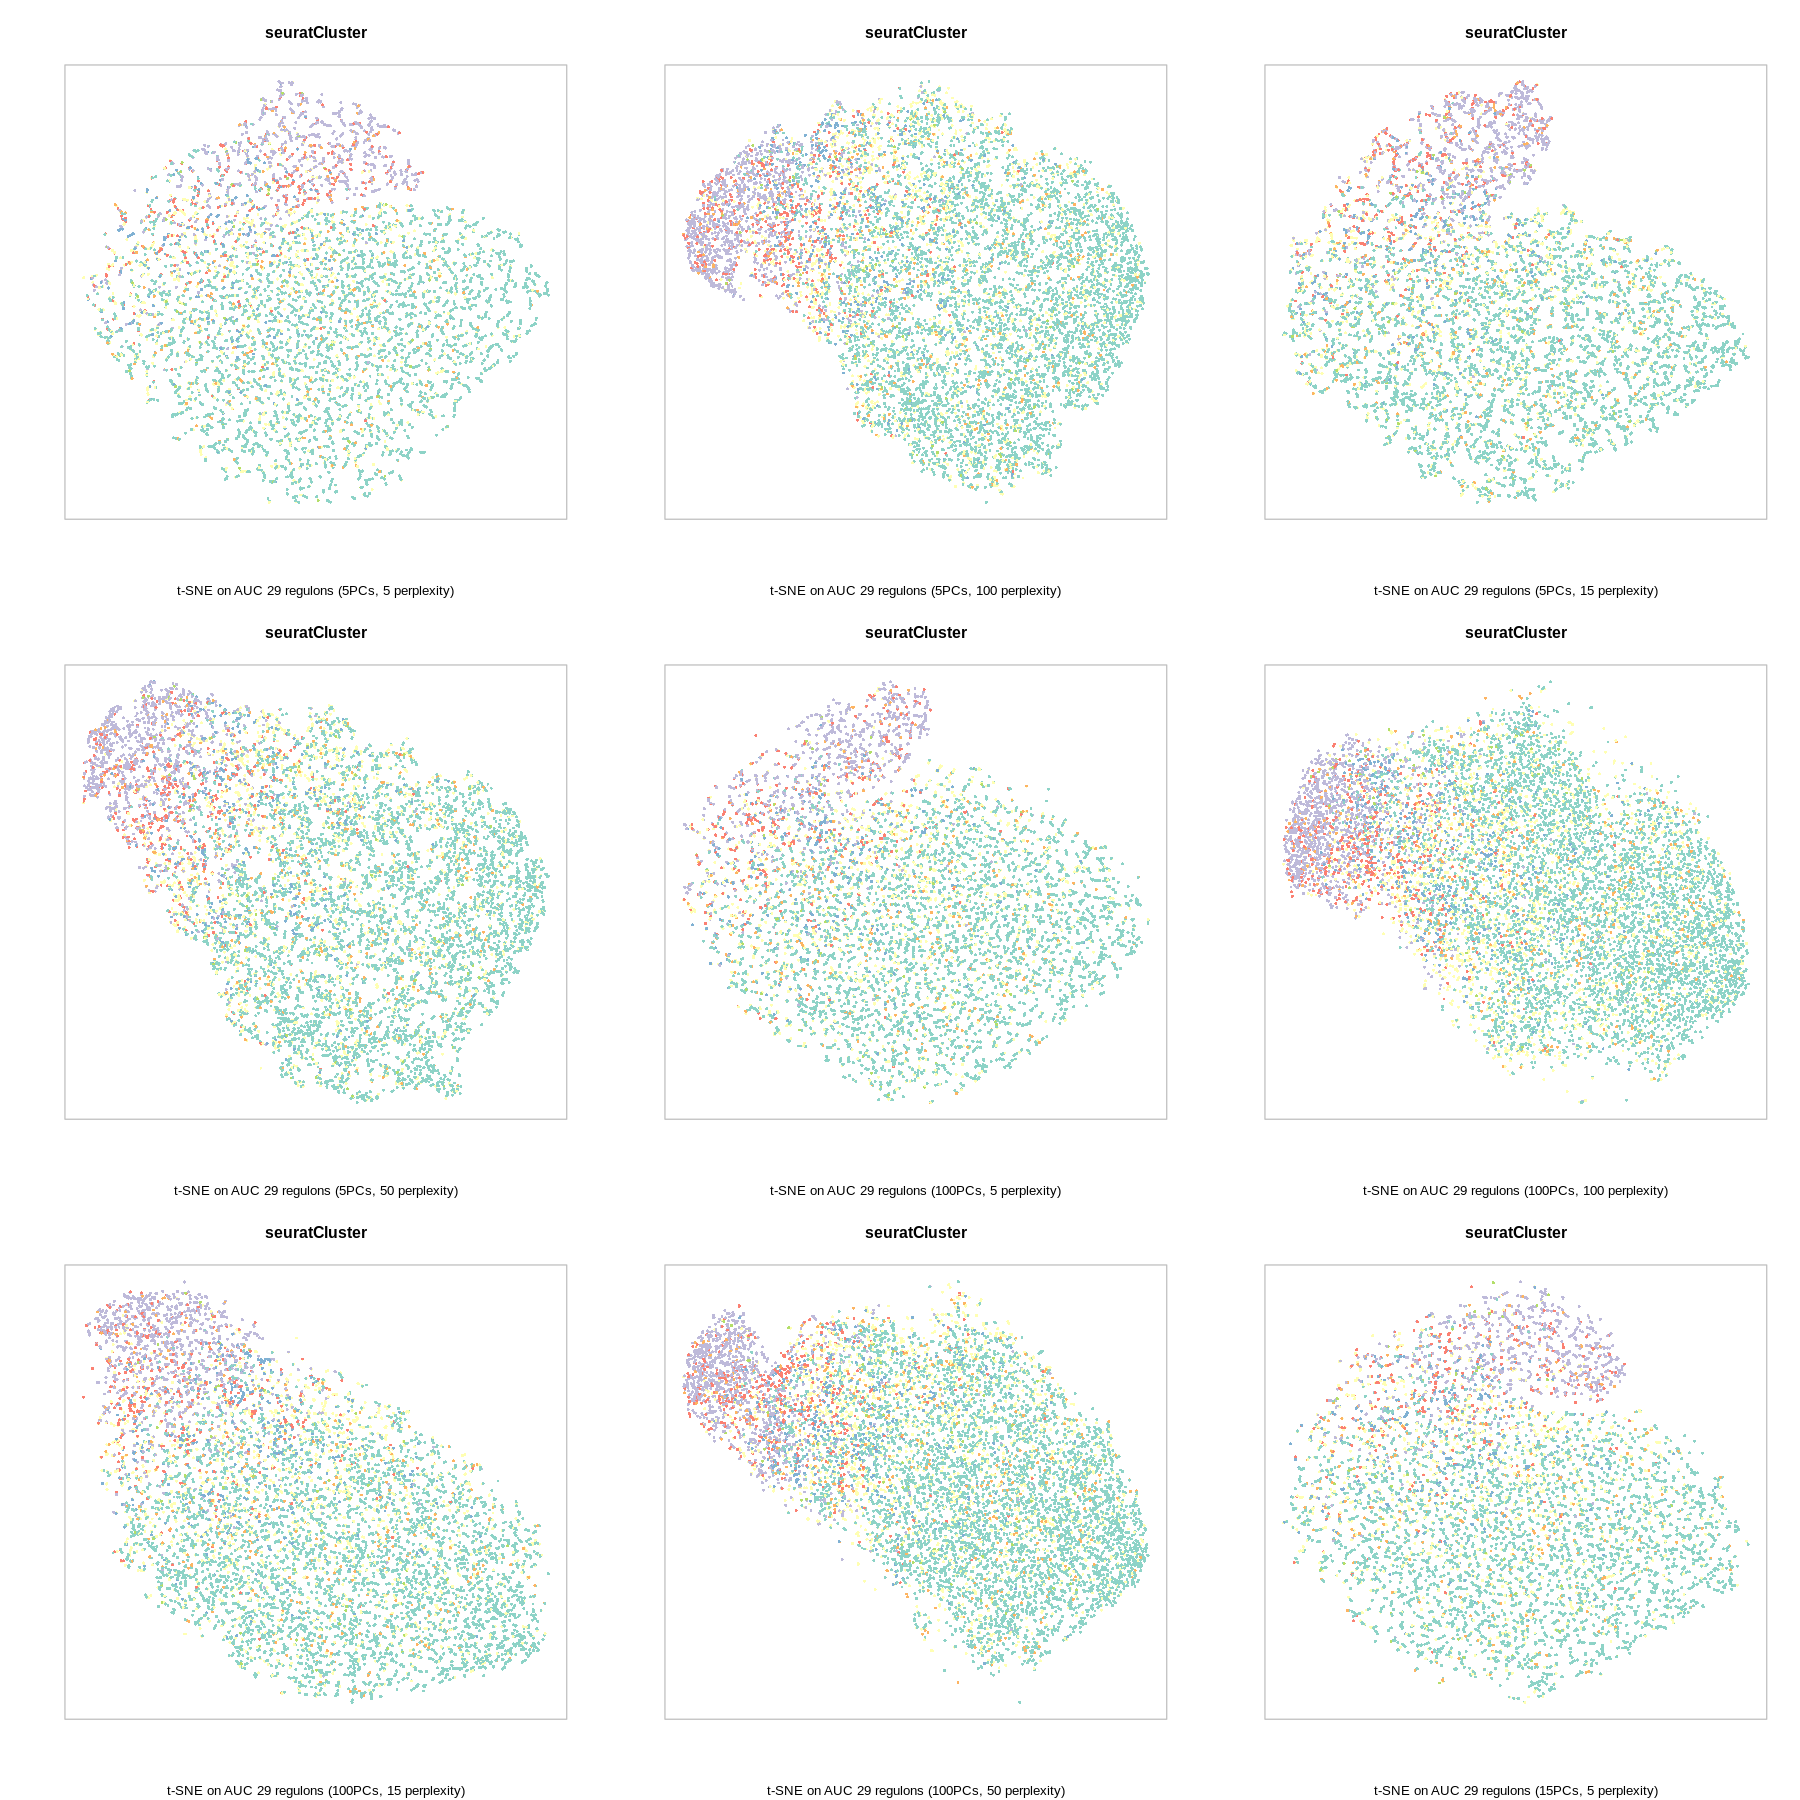

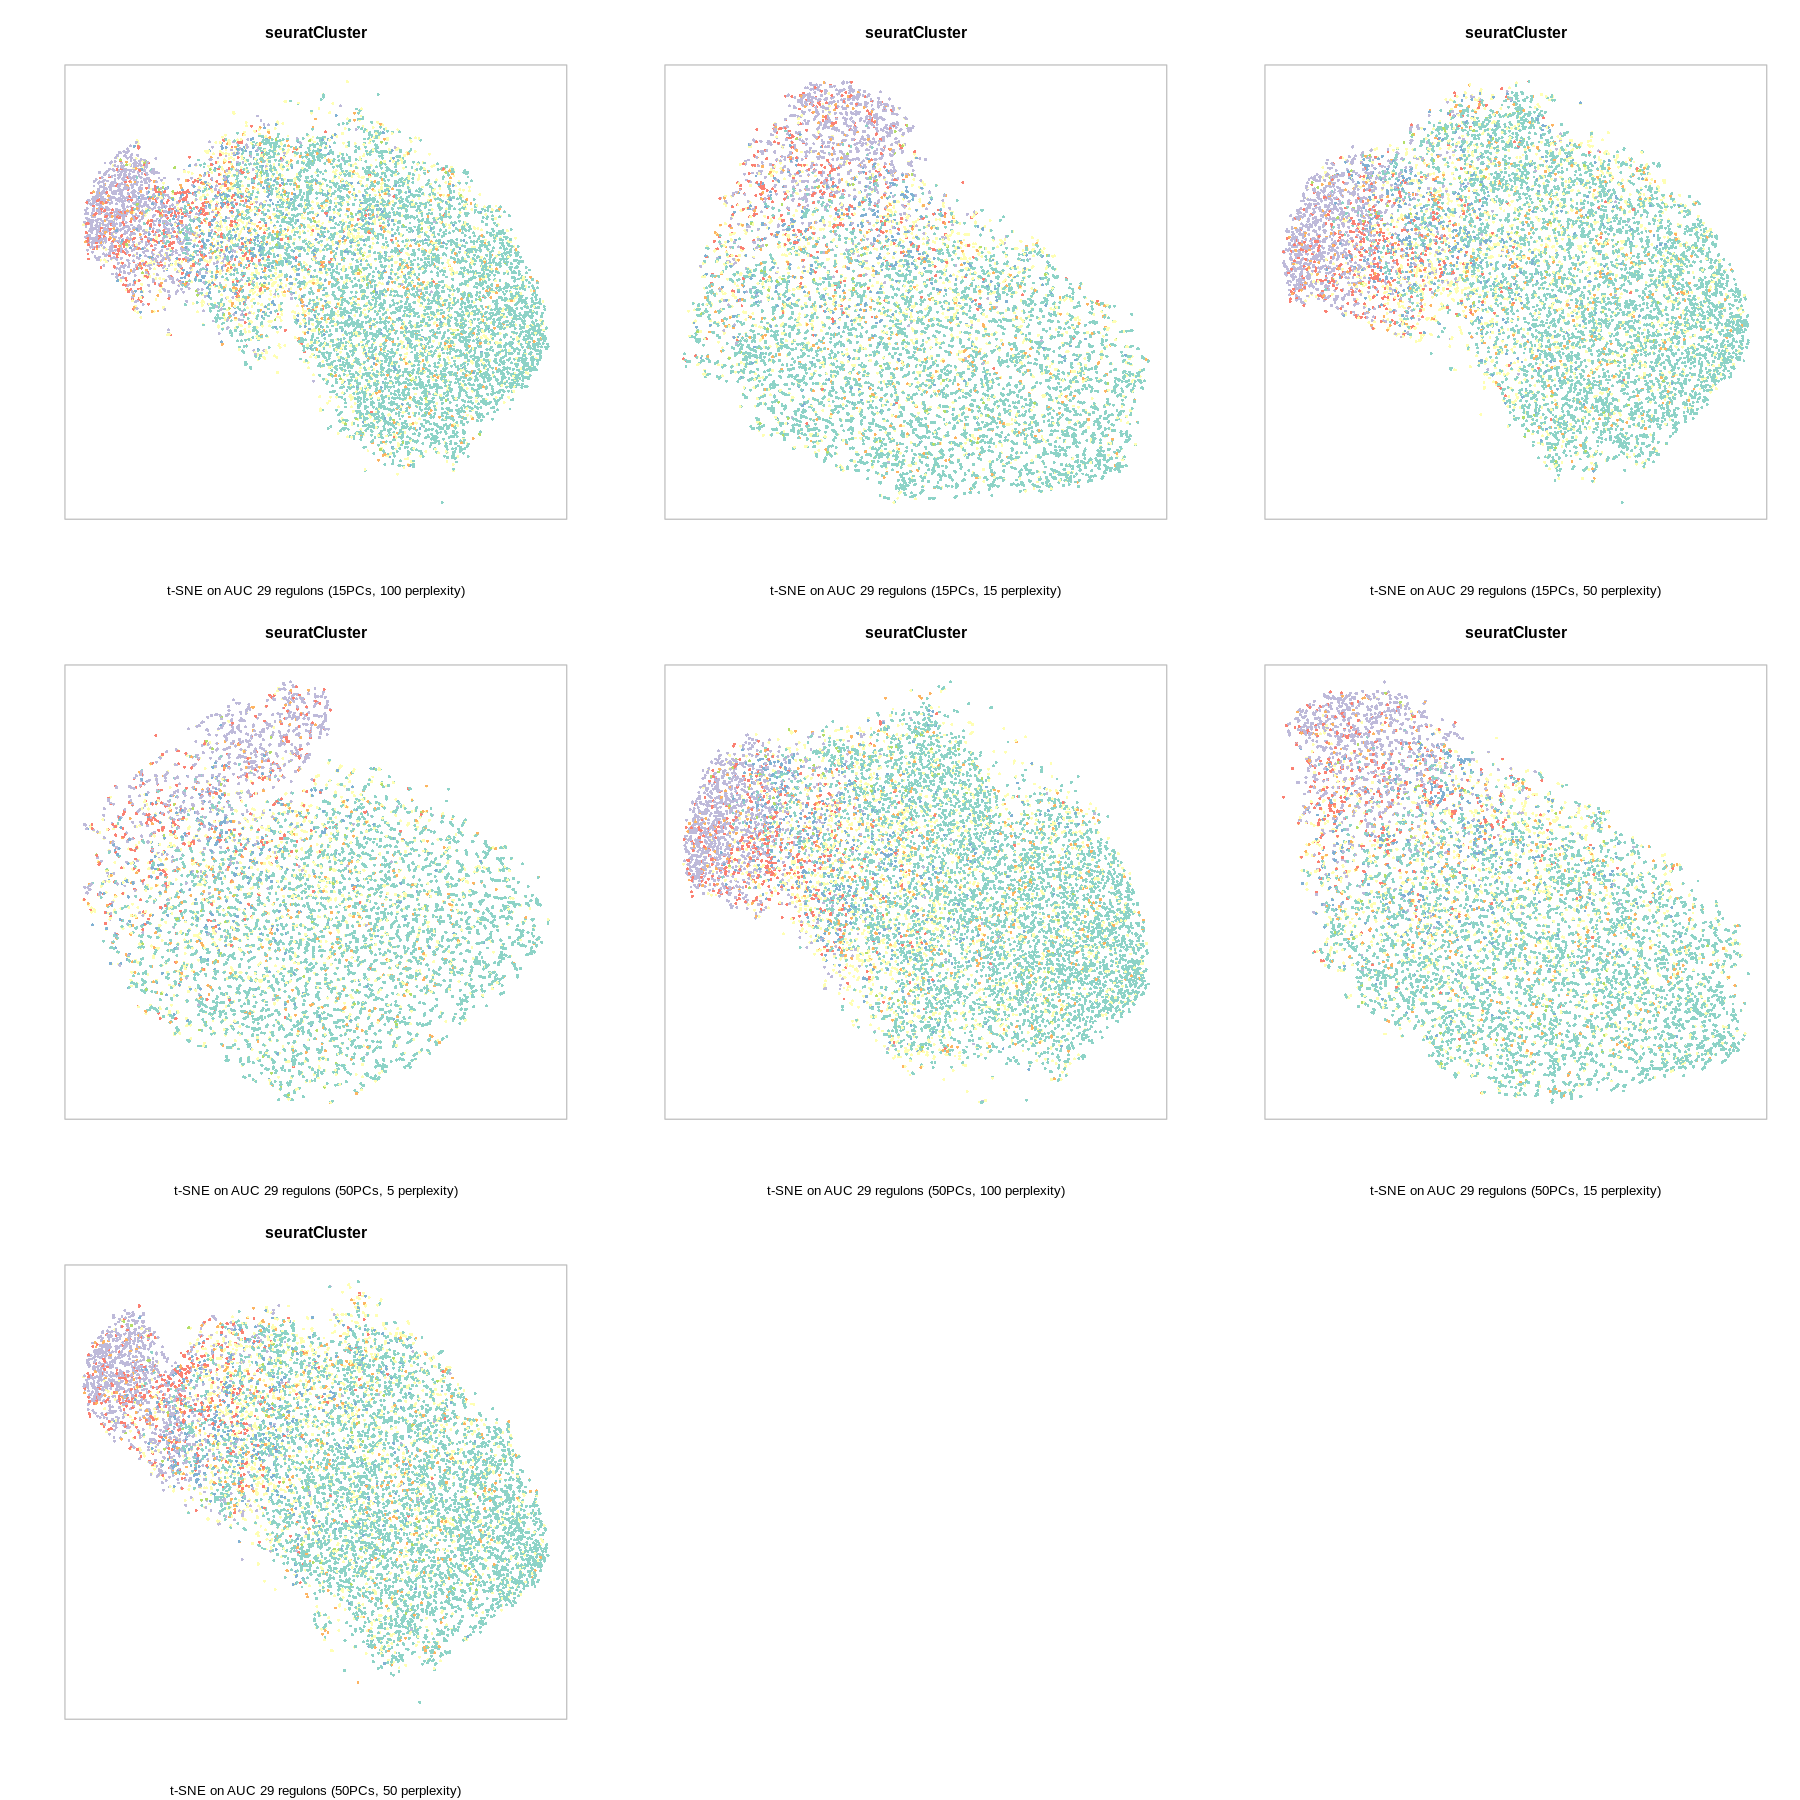

In [39]:
# Using only "high-confidence" regulons (normally similar)
par(mfrow=c(3,3))
fileNames <- paste0("int/",grep(".Rds", grep("tSNE_oHC_AUC", list.files("int"), value=T, perl = T), value=T))
plotTsne_compareSettings(fileNames, scenicOptions, showLegend=FALSE, varName="seuratCluster", cex=.5)

In [40]:
print(tsneFileName(scenicOptions))

[1] "int/tSNE_AUC_50pcs_50perpl.Rds"


In [41]:
tSNE_scenic <- readRDS(tsneFileName(scenicOptions))
aucell_regulonAUC <- loadInt(scenicOptions, "aucell_regulonAUC")

ERROR: Error in AUCell::AUCell_plotTSNE(tSNE_scenic$Y, exprMat_log, regulonAUC[regulonsToPlot, : object 'regulonAUC' not found


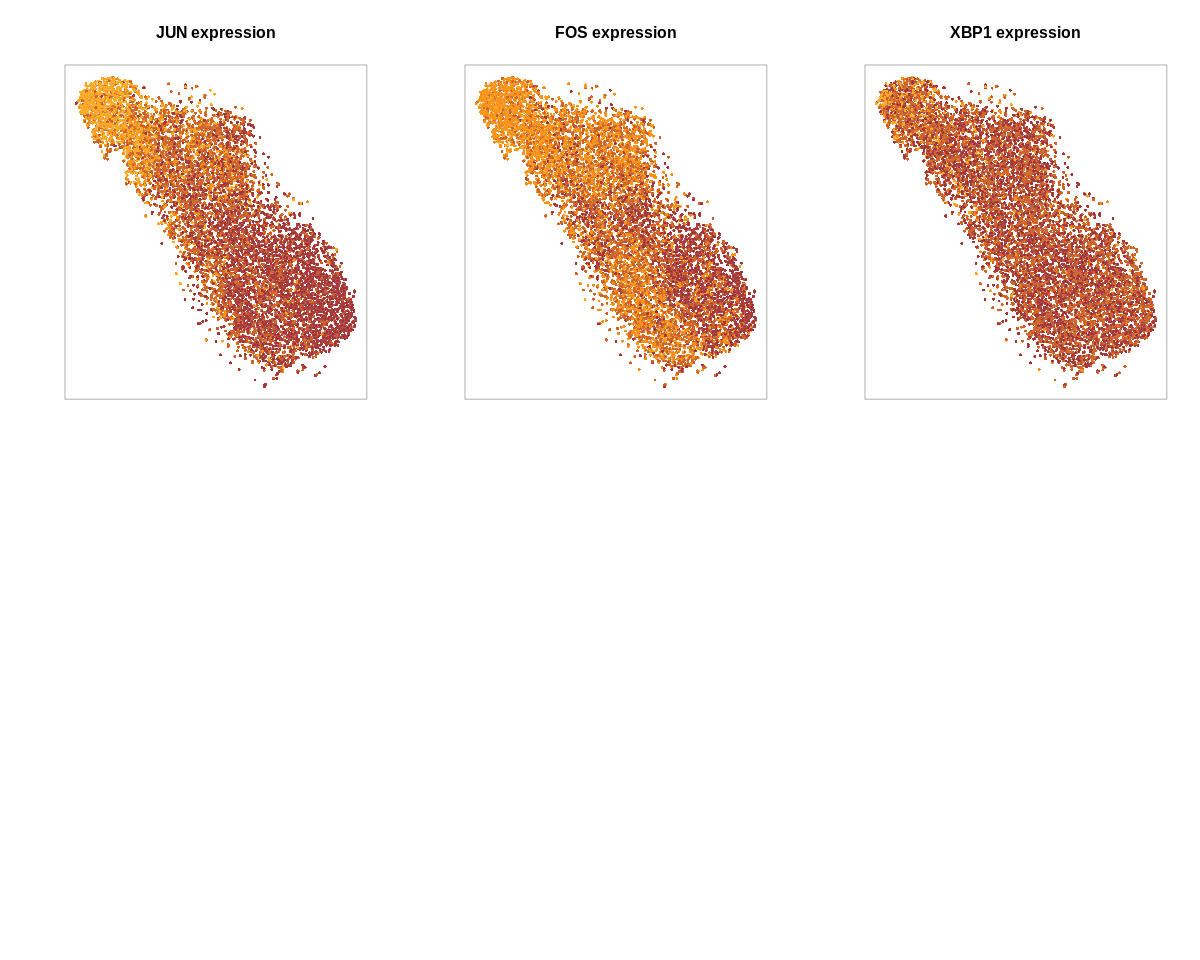

In [42]:
tfsToPlot <- c("JUN", "FOS", "XBP1") 
regulonsToPlot <-c("JUN (39g)","FOS (184g)","XBP1 (176g)")             
options(repr.plot.width=10, repr.plot.height=8) # To set the figure size in Jupyter
par(mfrow=c(2,3))
# Plot expression:
AUCell::AUCell_plotTSNE(tSNE_scenic$Y, exprMat_log[tfsToPlot,], plots=c("Expression"), cex = .5)
# Plot regulon activity:
AUCell::AUCell_plotTSNE(tSNE_scenic$Y, exprMat_log, regulonAUC[regulonsToPlot,], plots=c("AUC"), cex = .5)

In [43]:
library(BiocGenerics)


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min




In [44]:
regulons <- loadInt(scenicOptions, "aucell_regulons")
head(cbind(onlyNonDuplicatedExtended(names(regulons))))

[,1]               
IRF1  IRF1 (265g)        
IRF4  IRF4 (297g)        
STAT1 STAT1 (256g)       
MYC   MYC_extended (326g)
ATF3  ATF3 (218g)        
FOS   FOS (97g)

In [45]:
regulonTargetsInfo <- loadInt(scenicOptions, "regulonTargetsInfo")
tableSubset <- regulonTargetsInfo[TF=="JUN" & highConfAnnot==TRUE]
viewMotifs(tableSubset, options=list(pageLength=10)) 

HTML widgets cannot be represented in plain text (need html)

In [1]:
motifEnrichment_selfMotifs_wGenes <- loadInt(scenicOptions, "motifEnrichment_selfMotifs_wGenes")
tableSubset <- motifEnrichment_selfMotifs_wGenes[highlightedTFs=="JUN"]
viewMotifs(tableSubset) 

ERROR: Error in loadInt(scenicOptions, "motifEnrichment_selfMotifs_wGenes"): could not find function "loadInt"


In [2]:
scenicOptions <- readRDS("int/scenicOptions.Rds")
scenicOptions@settings$verbose <- TRUE
scenicOptions@settings$nCores <- 1
scenicOptions@settings$seed <- 123

Warning message in gzfile(file, "rb"):
“cannot open compressed file 'int/scenicOptions.Rds', probable reason 'No such file or directory'”


ERROR: Error in gzfile(file, "rb"): cannot open the connection


In [48]:
cellInfo <- data.frame(seuratCluster=Idents(allPC3))

In [49]:
cellInfo$nGene <- colSums(exprMat>0)
head(cellInfo)

seuratCluster nGene
AAACCTGAGGCCCTCA-1_3 0             1207 
AAACCTGAGTTTGCGT-1_3 2             1176 
AAACCTGGTACGCTGC-1_3 1             1346 
AAACCTGGTGAGTATA-1_3 2             1105 
AAACCTGGTTATCACG-1_3 1             1328 
AAACCTGGTTCCCGAG-1_3 0             1185

In [50]:
regulonAUC <- loadInt(scenicOptions, "aucell_regulonAUC")
regulonAUC <- regulonAUC[onlyNonDuplicatedExtended(rownames(regulonAUC)),]
regulonActivity_byCellType <- sapply(split(rownames(cellInfo), cellInfo$seuratCluster),
                                     function(cells) rowMeans(getAUC(regulonAUC)[,cells]))
regulonActivity_byCellType_Scaled <- t(scale(t(regulonActivity_byCellType), center = T, scale=T))
regulonActivity_byCellType_Scaled

0           1            2           3          
RUNX1 (15g)            -0.11539478  0.760943899  0.63393912 -0.18645783
CUX1 (27g)             -0.67763096  0.918845418  1.34447273 -0.09293917
BACH1 (11g)            -0.16414605  1.171558592  1.47798297  0.16226745
DDIT3 (14g)            -0.59233645  0.923031860  1.63160967  0.44177439
KLF13 (12g)            -1.17383688  0.017598902  1.14441476  1.56156987
ARID3A_extended (17g)  -0.03671265  1.710531030 -0.71402687 -0.29457228
NFIC_extended (60g)    -1.22713862  0.531001193  1.66538865  0.04992457
KLF3 (46g)             -1.45879796 -0.043663839  1.46955025  0.90494705
XRCC4_extended (67g)   -1.14471711 -0.650835858  0.41641948  1.29921980
SMARCC2_extended (23g) -1.09388273 -0.209332255  1.16887161 -0.16278512
CEBPG (107g)           -0.44755912  0.679387250  0.49651975  1.64853612
BCLAF1_extended (46g)  -0.04377043 -0.559879600 -1.01426318  1.87453272
XBP1 (55g)             -0.23666502 -0.795524639 -1.16387948  0.22518870
KLF6_extended (23g)     0.64416534  0.538859027 -1.28252928 -0.99625373
KLF2_extended (18g)    -0.44184192  0.602817834 -1.32244178  0.06448767
IRF9 (19g)             -1.66173931  1.287923893  0.57146705  0.85297247
GABPB1 (168g)           0.12326818  1.410818207 -1.09971793 -1.28901117
BHLHE41_extended (98g)  0.92580308  1.223112352 -1.29995596 -1.21440704
ATF3 (218g)             1.08681931  0.960623389 -1.61651678 -1.04860972
STAT1 (256g)            1.27930764  0.296554730 -0.92166410 -1.63337408
IRF4 (297g)             0.94545542  0.239639481 -1.52936156 -1.07979385
IRF1 (265g)             0.72705903  0.655044751 -1.27097409 -1.62979979
BCL11A_extended (272g)  0.70935507  0.854793641 -1.87131123 -0.70700121
PRDM1_extended (38g)    1.10972075  0.805407923 -1.74752288 -0.45839808
FOS (97g)               1.09155031  0.540147597 -1.82638902 -0.70223285
IRF7 (112g)             1.07502584  0.951313720 -1.79783707 -0.72515652
FOXO3 (21g)             0.91684220  0.441695485 -1.69617632 -1.07461700
JUND (38g)              1.16070620  0.852413281 -1.65922402 -0.99977117
CEBPB (196g)            1.21213084  0.622058701 -1.74453705 -0.85984766
EGR1 (22g)              1.29609356  0.668320960 -1.43783176 -1.12476927
JUNB (55g)              1.26288978  0.675271574 -1.55056816 -1.07535721
MYC_extended (326g)     1.11741393  0.682443290 -1.52648261 -1.12377703
CREB3L2 (57g)           1.34795730  0.649303295 -1.30222853 -1.29071257
TGIF1 (10g)             1.31039120  0.441807730 -1.34337013 -1.15639846
JUN (38g)               1.33528676  0.605162540 -1.67103672 -0.92829954
FOSB (34g)              1.33692751  0.595341632 -1.65905884 -0.94170669
ARID5B (124g)           1.19726878  0.633818229 -1.64754089 -1.00417879
ATF5 (65g)              1.21327961  0.513546173 -1.68637560 -0.96975841
ATF6_extended (121g)    0.71952857  0.002235289 -1.41979955 -1.08762801
NR3C1 (23g)             0.59984274  1.227714232 -1.27987092 -1.44509490
RELB (69g)              1.06430864  0.310189620  0.06471273 -1.89008297
                       4            5           6           
RUNX1 (15g)            -1.957202069  1.05134621 -0.187174544
CUX1 (27g)             -1.396151294  0.63228627 -0.728882991
BACH1 (11g)            -0.789959784 -0.78712101 -1.070582174
DDIT3 (14g)            -0.790593048 -0.72572346 -0.887762970
KLF13 (12g)            -0.305770269 -0.56551889 -0.678457498
ARID3A_extended (17g)   0.801456862 -0.11761648 -1.349059616
NFIC_extended (60g)    -0.817131274  0.51055040 -0.712594909
KLF3 (46g)             -0.701584581 -0.52382962  0.353378704
XRCC4_extended (67g)    1.279023374 -0.44171739 -0.757392302
SMARCC2_extended (23g) -0.802691258 -0.47910075  1.578920502
CEBPG (107g)           -0.283471642 -1.27295466 -0.820457704
BCLAF1_extended (46g)   0.444094918 -0.94166746  0.240953031
XBP1 (55g)              1.976167754 -0.01925477  0.013967458
KLF6_extended (23g)    -0.786996858  1.30574770  0.577007791
KLF2_extended (18g)     0.017119149  1.78593005 -0.706071001
IRF9 (19g)             

In [51]:
regulonAUC <- loadInt(scenicOptions, "aucell_regulonAUC")
regulonAUC <- regulonAUC[onlyNonDuplicatedExtended(rownames(regulonAUC)),]
regulonActivity_byCellType <- sapply(split(rownames(cellInfo), cellInfo$seuratCluster),
                                     function(cells) rowMeans(getAUC(regulonAUC)[,cells]))
regulonActivity_byCellType_Scaled <- t(scale(t(regulonActivity_byCellType), center = T, scale=T))
regulonActivity_byCellType_Scaled

0           1            2           3          
RUNX1 (15g)            -0.11539478  0.760943899  0.63393912 -0.18645783
CUX1 (27g)             -0.67763096  0.918845418  1.34447273 -0.09293917
BACH1 (11g)            -0.16414605  1.171558592  1.47798297  0.16226745
DDIT3 (14g)            -0.59233645  0.923031860  1.63160967  0.44177439
KLF13 (12g)            -1.17383688  0.017598902  1.14441476  1.56156987
ARID3A_extended (17g)  -0.03671265  1.710531030 -0.71402687 -0.29457228
NFIC_extended (60g)    -1.22713862  0.531001193  1.66538865  0.04992457
KLF3 (46g)             -1.45879796 -0.043663839  1.46955025  0.90494705
XRCC4_extended (67g)   -1.14471711 -0.650835858  0.41641948  1.29921980
SMARCC2_extended (23g) -1.09388273 -0.209332255  1.16887161 -0.16278512
CEBPG (107g)           -0.44755912  0.679387250  0.49651975  1.64853612
BCLAF1_extended (46g)  -0.04377043 -0.559879600 -1.01426318  1.87453272
XBP1 (55g)             -0.23666502 -0.795524639 -1.16387948  0.22518870
KLF6_extended (23g)     0.64416534  0.538859027 -1.28252928 -0.99625373
KLF2_extended (18g)    -0.44184192  0.602817834 -1.32244178  0.06448767
IRF9 (19g)             -1.66173931  1.287923893  0.57146705  0.85297247
GABPB1 (168g)           0.12326818  1.410818207 -1.09971793 -1.28901117
BHLHE41_extended (98g)  0.92580308  1.223112352 -1.29995596 -1.21440704
ATF3 (218g)             1.08681931  0.960623389 -1.61651678 -1.04860972
STAT1 (256g)            1.27930764  0.296554730 -0.92166410 -1.63337408
IRF4 (297g)             0.94545542  0.239639481 -1.52936156 -1.07979385
IRF1 (265g)             0.72705903  0.655044751 -1.27097409 -1.62979979
BCL11A_extended (272g)  0.70935507  0.854793641 -1.87131123 -0.70700121
PRDM1_extended (38g)    1.10972075  0.805407923 -1.74752288 -0.45839808
FOS (97g)               1.09155031  0.540147597 -1.82638902 -0.70223285
IRF7 (112g)             1.07502584  0.951313720 -1.79783707 -0.72515652
FOXO3 (21g)             0.91684220  0.441695485 -1.69617632 -1.07461700
JUND (38g)              1.16070620  0.852413281 -1.65922402 -0.99977117
CEBPB (196g)            1.21213084  0.622058701 -1.74453705 -0.85984766
EGR1 (22g)              1.29609356  0.668320960 -1.43783176 -1.12476927
JUNB (55g)              1.26288978  0.675271574 -1.55056816 -1.07535721
MYC_extended (326g)     1.11741393  0.682443290 -1.52648261 -1.12377703
CREB3L2 (57g)           1.34795730  0.649303295 -1.30222853 -1.29071257
TGIF1 (10g)             1.31039120  0.441807730 -1.34337013 -1.15639846
JUN (38g)               1.33528676  0.605162540 -1.67103672 -0.92829954
FOSB (34g)              1.33692751  0.595341632 -1.65905884 -0.94170669
ARID5B (124g)           1.19726878  0.633818229 -1.64754089 -1.00417879
ATF5 (65g)              1.21327961  0.513546173 -1.68637560 -0.96975841
ATF6_extended (121g)    0.71952857  0.002235289 -1.41979955 -1.08762801
NR3C1 (23g)             0.59984274  1.227714232 -1.27987092 -1.44509490
RELB (69g)              1.06430864  0.310189620  0.06471273 -1.89008297
                       4            5           6           
RUNX1 (15g)            -1.957202069  1.05134621 -0.187174544
CUX1 (27g)             -1.396151294  0.63228627 -0.728882991
BACH1 (11g)            -0.789959784 -0.78712101 -1.070582174
DDIT3 (14g)            -0.790593048 -0.72572346 -0.887762970
KLF13 (12g)            -0.305770269 -0.56551889 -0.678457498
ARID3A_extended (17g)   0.801456862 -0.11761648 -1.349059616
NFIC_extended (60g)    -0.817131274  0.51055040 -0.712594909
KLF3 (46g)             -0.701584581 -0.52382962  0.353378704
XRCC4_extended (67g)    1.279023374 -0.44171739 -0.757392302
SMARCC2_extended (23g) -0.802691258 -0.47910075  1.578920502
CEBPG (107g)           -0.283471642 -1.27295466 -0.820457704
BCLAF1_extended (46g)   0.444094918 -0.94166746  0.240953031
XBP1 (55g)              1.976167754 -0.01925477  0.013967458
KLF6_extended (23g)    -0.786996858  1.30574770  0.577007791
KLF2_extended (18g)     0.017119149  1.78593005 -0.706071001
IRF9 (19g)             

In [52]:
options(repr.plot.height=15,repr.plot.width=15)

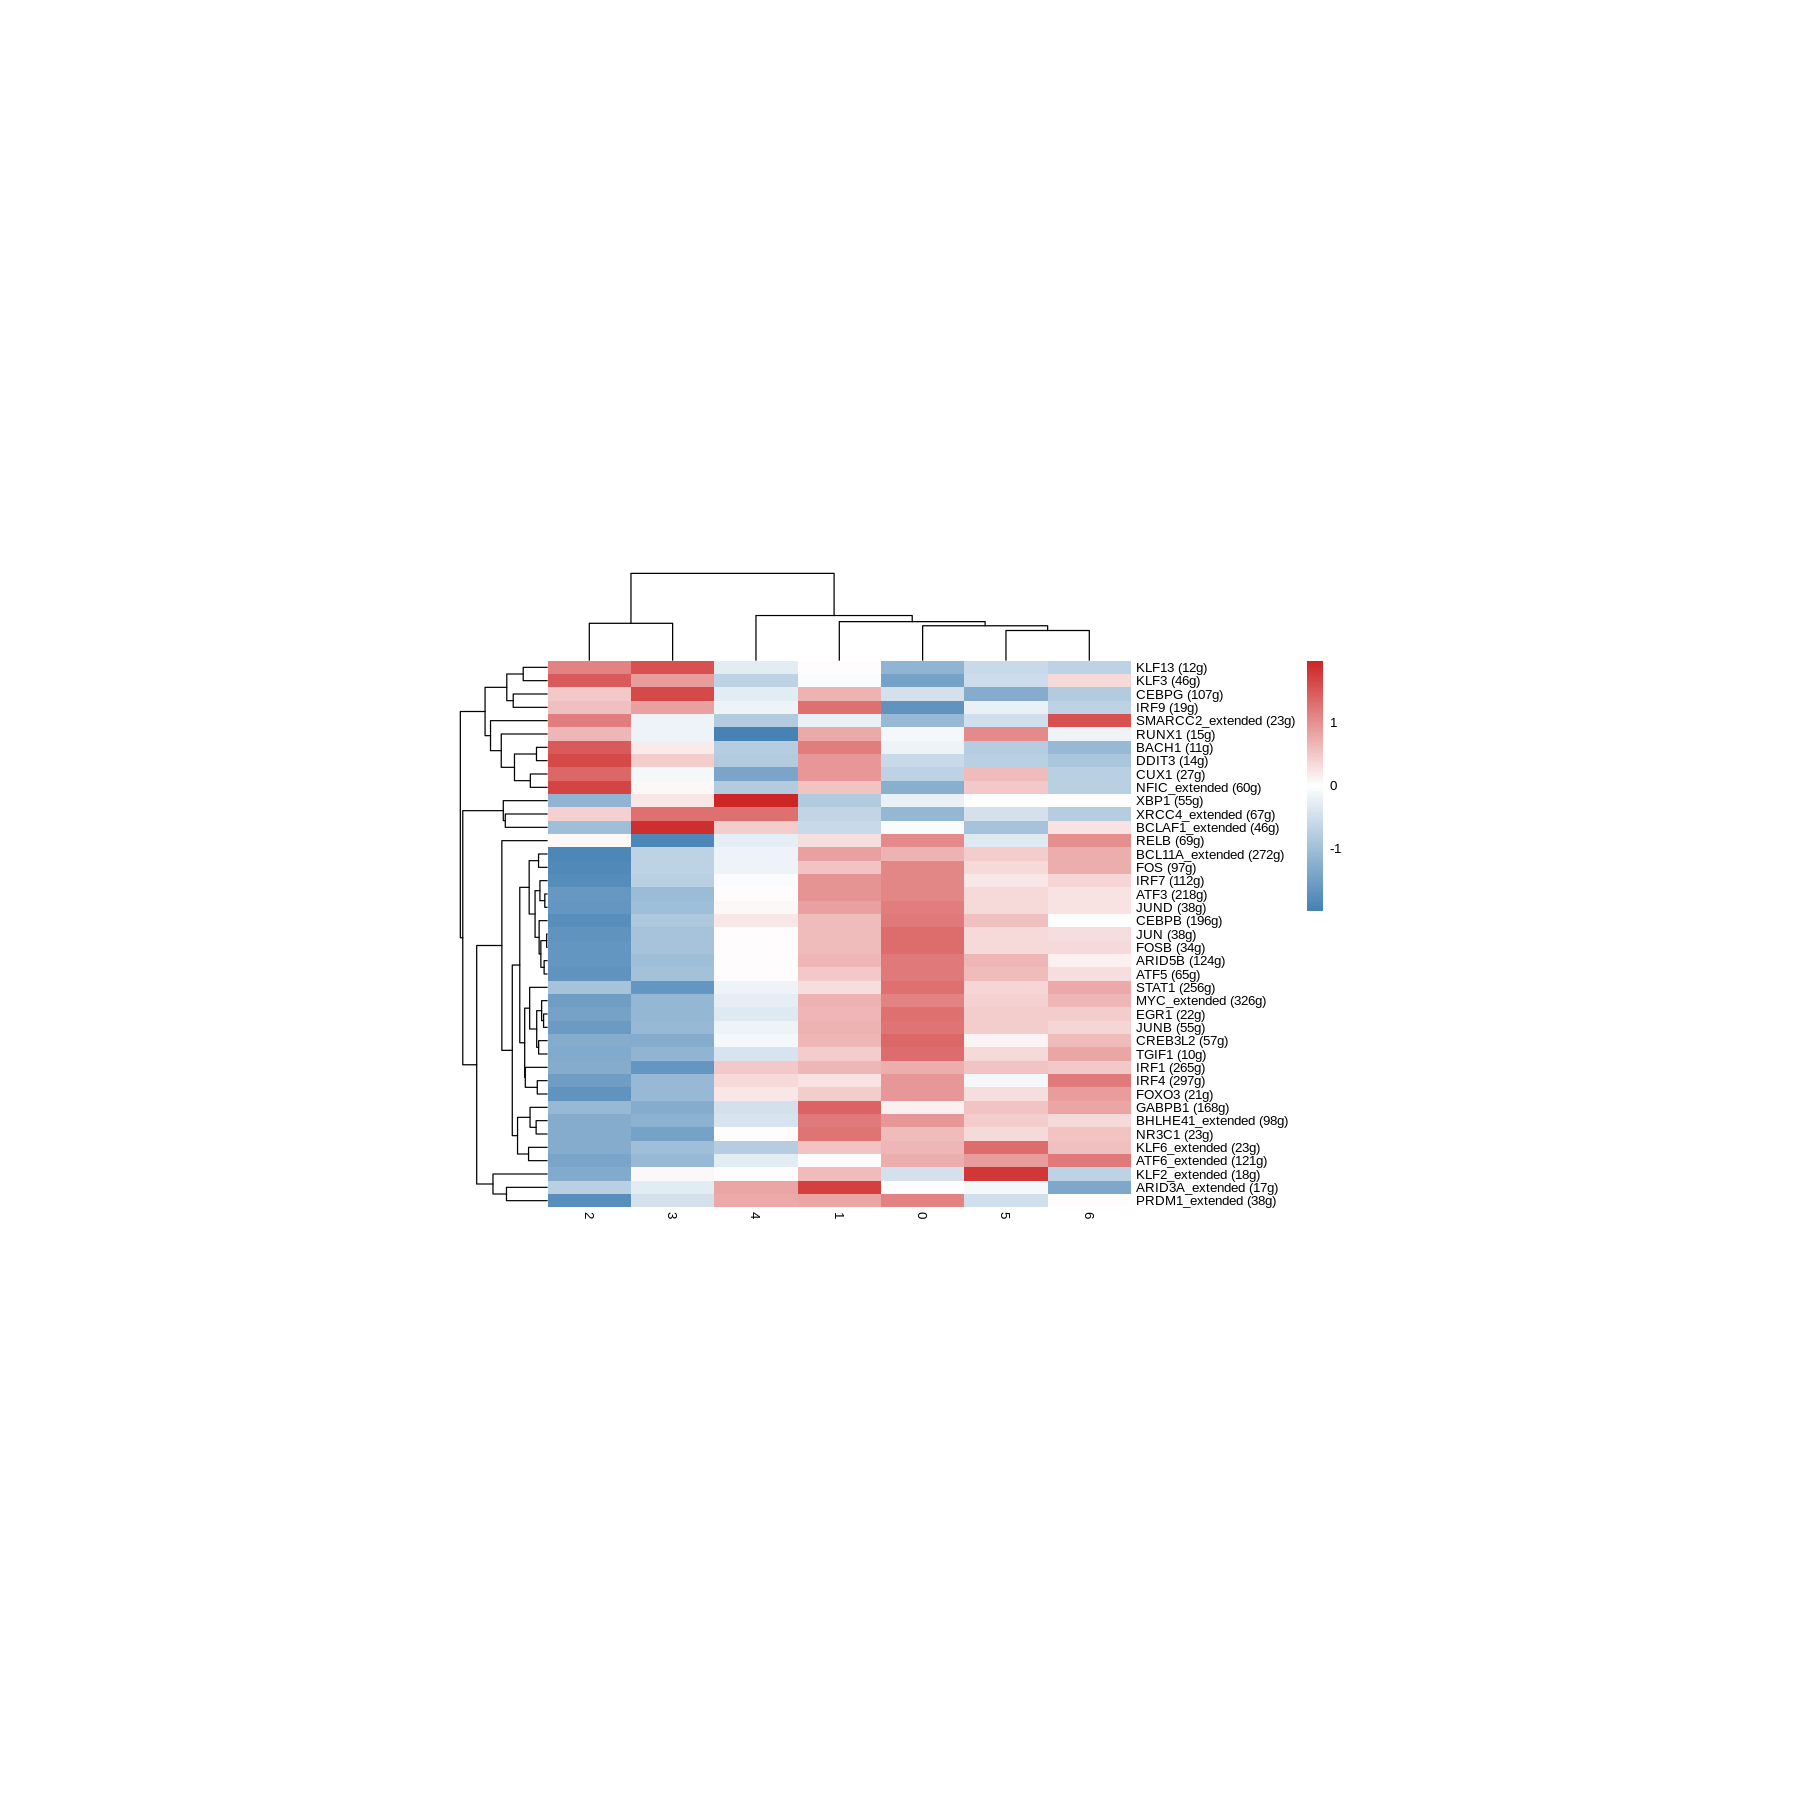

In [53]:
library(pheatmap)
pheatmap(regulonActivity_byCellType_Scaled,scale="row",border=FALSE,color=colorRampPalette(c("steelblue","white","firebrick3"))(100),cellheight=8,cellwidth=50,fontsize=8)

In [54]:
topRegulators <- reshape2::melt(regulonActivity_byCellType_Scaled)
colnames(topRegulators) <- c("Regulon", "seuratCluster", "RelativeActivity")
topRegulators <- topRegulators[which(topRegulators$RelativeActivity>0),]
viewTable(topRegulators)

HTML widgets cannot be represented in plain text (need html)

In [55]:
minPerc <- 0.3
binaryRegulonActivity <- loadInt(scenicOptions, "aucell_binary_nonDupl")
cellInfo_binarizedCells <- cellInfo[which(rownames(cellInfo)%in% colnames(binaryRegulonActivity)),, drop=FALSE]
regulonActivity_byCellType_Binarized <- sapply(split(rownames(cellInfo_binarizedCells), cellInfo_binarizedCells$seuratCluster), 
                                               function(cells) rowMeans(binaryRegulonActivity[,cells, drop=FALSE]))
#binaryActPerc_subset <- regulonActivity_byCellType_Binarized[which(rowSums(regulonActivity_byCellType_Binarized>minPerc)>0),]

In [56]:
options(repr.plot.height=15,repr.plot.width=15)

In [57]:
regulonActivity_byCellType_Binarized

0            1            2            3          
ARID3A_extended (17g)   0.2292235661 0.3572526909 0.1856127886 0.219298246
ARID5B (124g)           0.1685524776 0.0943106099 0.0000000000 0.004385965
ATF3 (218g)             0.0001950839 0.0000000000 0.0000000000 0.000000000
ATF5 (65g)              0.2395630121 0.1045617632 0.0008880995 0.004385965
ATF6_extended (121g)    0.0000000000 0.0005125577 0.0000000000 0.000000000
BACH1 (11g)             0.0183378853 0.0328036904 0.0319715808 0.024122807
BCLAF1_extended (46g)   0.9453765119 0.8739108150 0.8206039076 0.934210526
BHLHE41_extended (98g)  0.0893484198 0.0968733983 0.0133214920 0.024122807
CEBPG (107g)            0.9504486929 0.9287544849 0.8623445826 0.960526316
CREB3L2_extended (220g) 0.0103394460 0.0030753460 0.0000000000 0.000000000
CUX1 (27g)              0.9814670308 0.9651460789 0.9138543517 0.701754386
DDIT3 (14g)             0.0267264924 0.0620194772 0.0728241563 0.048245614
EGR1 (22g)              0.3581740148 0.2224500256 0.0044404973 0.008771930
FOS (97g)               0.0083886071 0.0071758073 0.0000000000 0.002192982
FOSB (34g)              0.4036285603 0.1860584316 0.0026642984 0.008771930
FOXO3 (21g)             0.7442450254 0.6145566376 0.2388987567 0.355263158
GABPB1 (168g)           0.0027311744 0.0117888262 0.0124333925 0.002192982
IRF1 (265g)             1.0000000000 1.0000000000 0.9991119005 0.997807018
IRF9 (19g)              0.0376511900 0.1814454126 0.1492007105 0.164473684
JUN (38g)               0.4049941475 0.1855458739 0.0017761989 0.008771930
JUNB (55g)              0.3765119001 0.2091235264 0.0035523979 0.006578947
JUND_extended (120g)    0.1110027312 0.0666324962 0.0000000000 0.000000000
KLF13 (12g)             0.0294576668 0.0702203998 0.1056838366 0.120614035
KLF2_extended (18g)     0.0009754194 0.0046130190 0.0026642984 0.002192982
KLF3 (46g)              0.0435037066 0.1619682214 0.2699822380 0.225877193
KLF6_extended (23g)     0.0000000000 0.0005125577 0.0000000000 0.000000000
MYC_extended (326g)     0.0085836910 0.0066632496 0.0000000000 0.000000000
NFIC_extended (60g)     0.0530628170 0.2434648898 0.3543516874 0.199561404
NR3C1 (23g)             0.0003901678 0.0005125577 0.0008880995 0.000000000
PRDM1_extended (38g)    0.0000000000 0.0010251153 0.0000000000 0.000000000
RUNX1 (15g)             0.9814670308 0.9548949257 0.9120781528 0.684210526
SMARCC2_extended (23g)  0.0218493952 0.0773962071 0.1545293073 0.067982456
TGIF1 (10g)             0.9884900507 0.8892875448 0.3943161634 0.482456140
XRCC4_extended (67g)    0.1373390558 0.2116863147 0.3667850799 0.517543860
                        4           5           6         
ARID3A_extended (17g)   0.284386617 0.223376623 0.11235955
ARID5B (124g)           0.022304833 0.114285714 0.01123596
ATF3 (218g)             0.000000000 0.000000000 0.00000000
ATF5 (65g)              0.013011152 0.174025974 0.11235955
ATF6_extended (121g)    0.000000000 0.000000000 0.00000000
BACH1 (11g)             0.011152416 0.010389610 0.01123596
BCLAF1_extended (46g)   0.960966543 0.909090909 0.97752809
BHLHE41_extended (98g)  0.027881041 0.059740260 0.04494382
CEBPG (107g)            0.947955390 0.880519481 0.92134831
CREB3L2_extended (220g) 0.000000000 0.002597403 0.00000000
CUX1 (27g)              0.483271375 0.963636364 0.97752809
DDIT3 (14g)             0.027881041 0.018181818 0.02247191
EGR1 (22g)              0.040892193 0.210389610 0.19101124
FOS (97g)               0.000000000 0.010389610 0.00000000
FOSB (34g)              0.052044610 0.194805195 0.21348315
FOXO3 (21g)             0.628252788 0.592207792 0.71910112
GABPB1 (168g)           0.000000000 0.010389610 0.01123596
IRF1 (265g)             1.000000000 0.997402597 1.00000000
IRF9 (19g)              0.130111524 0.114285714 0.07865169
JUN (38g)               0.061338290 0.179220779 0.17977528
JUNB (55g)              0.046468401 0.236363636 0.24719101
JUND_extended (120g)    0.007434944 0.085714286 0.01123596
KLF13 (12g)             0.055762082 0.0415

In [58]:
binaryActPerc_subset <- regulonActivity_byCellType_Binarized

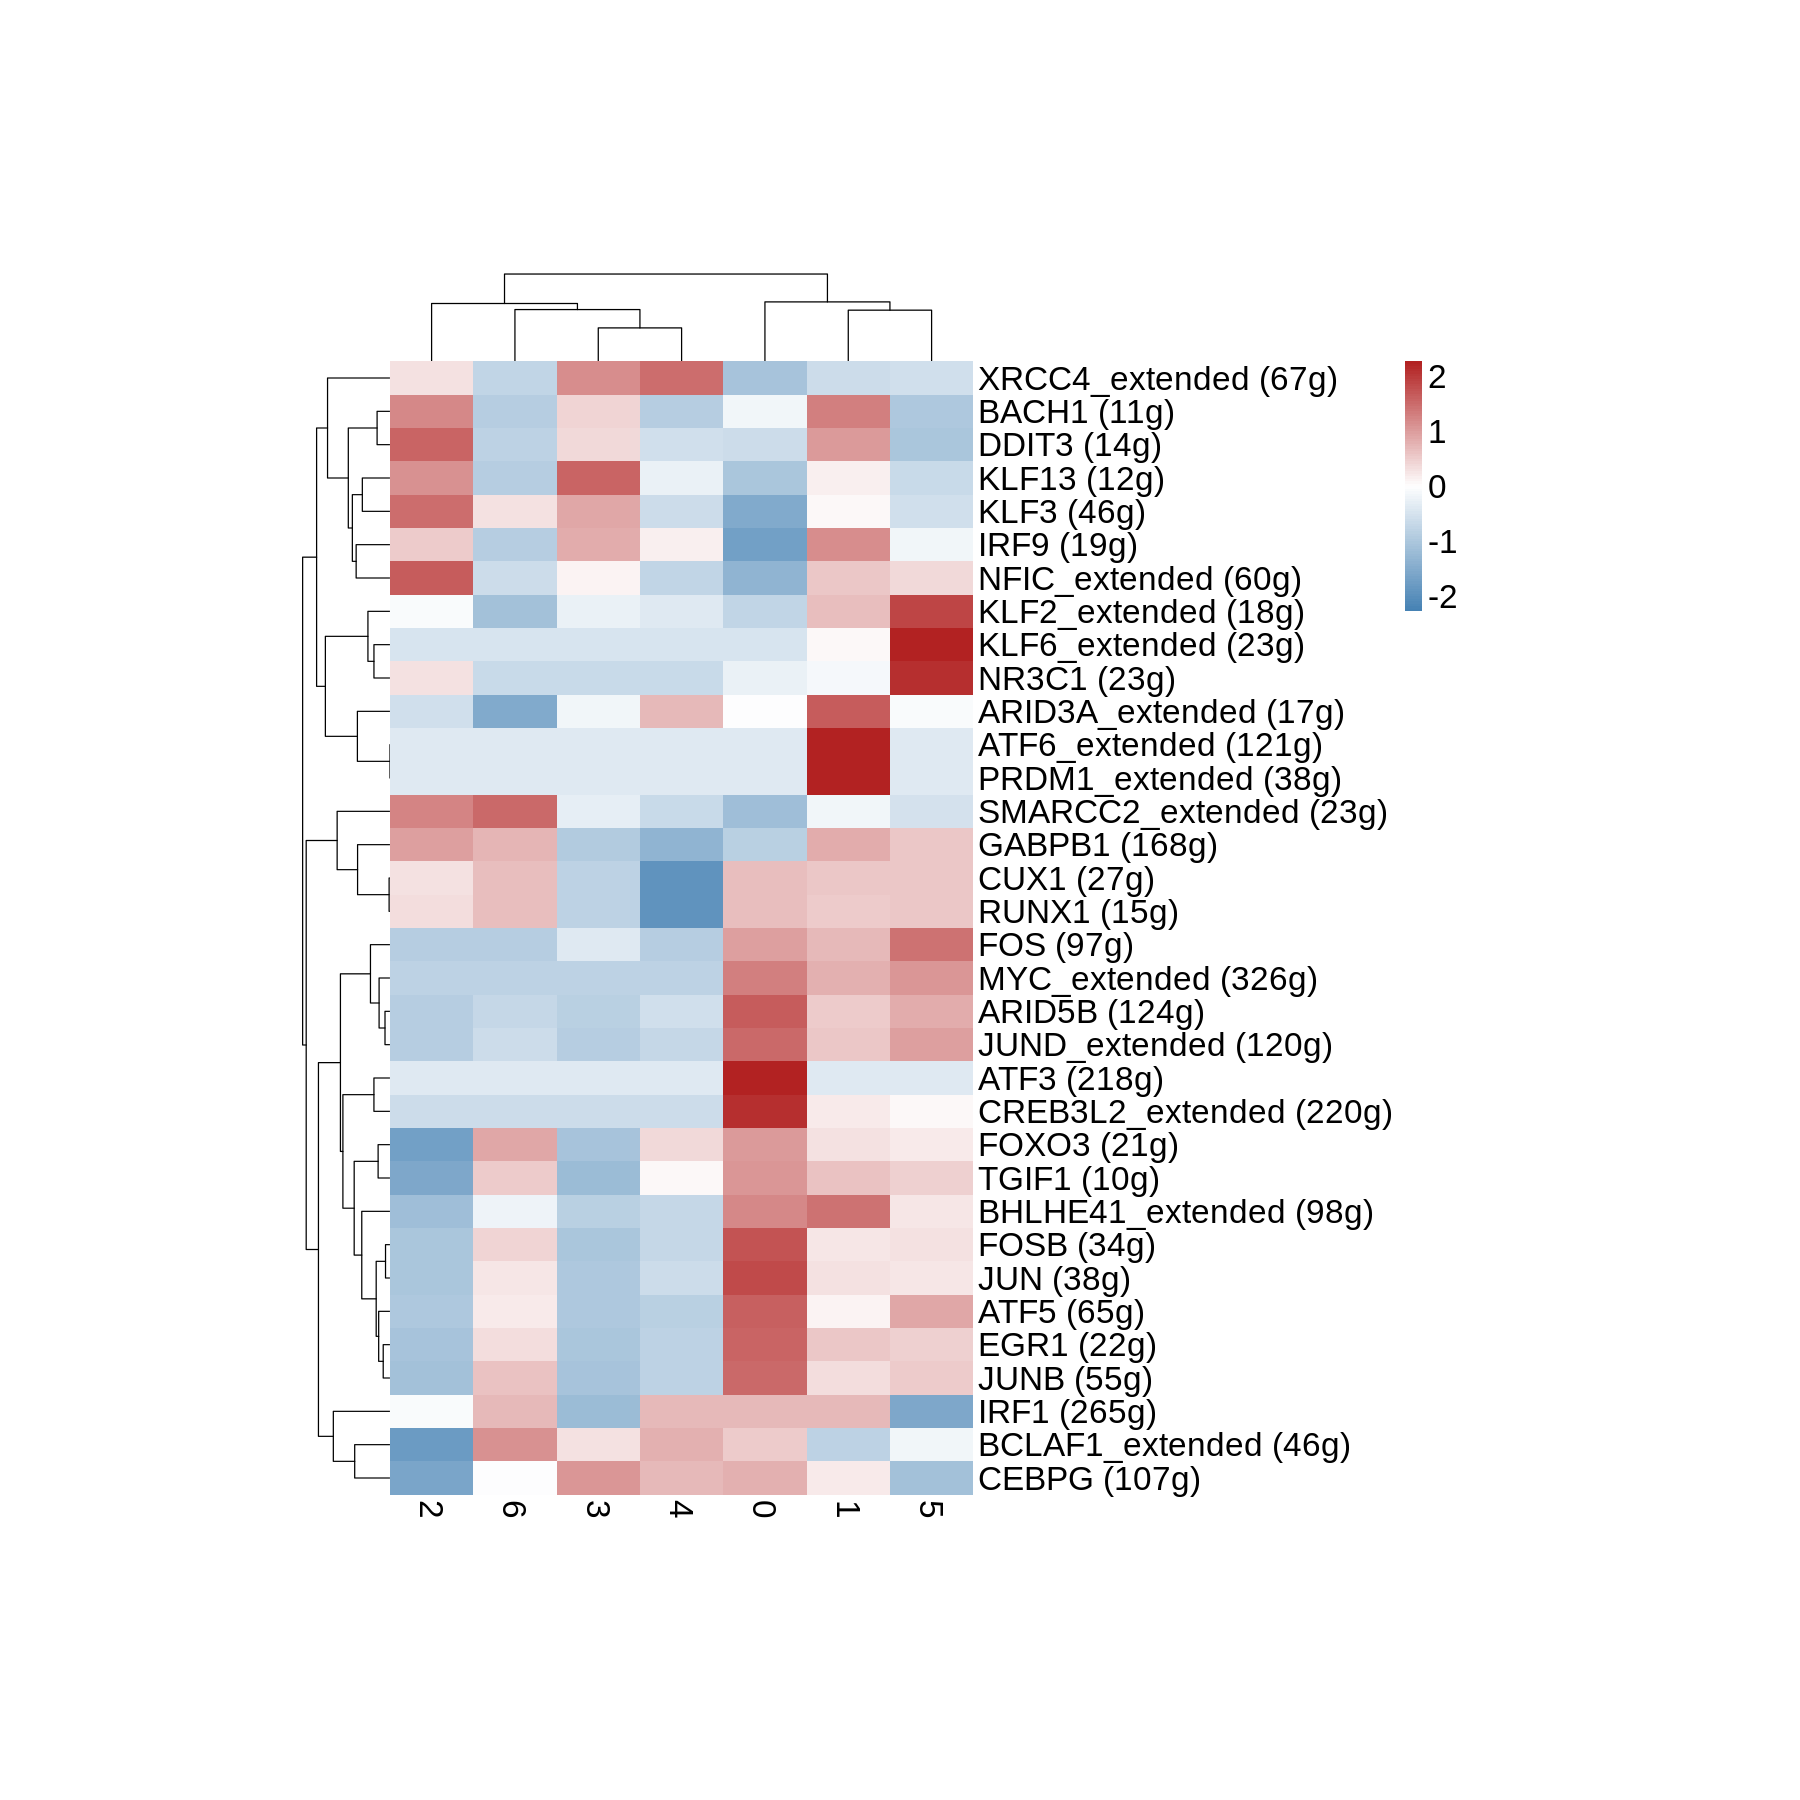

In [59]:
library(pheatmap)
pheatmap(binaryActPerc_subset ,scale="row",border=FALSE,color=colorRampPalette(c('steelblue',"white","firebrick"))(100),cellheight=20,cellwidth=50,fontsize=20)

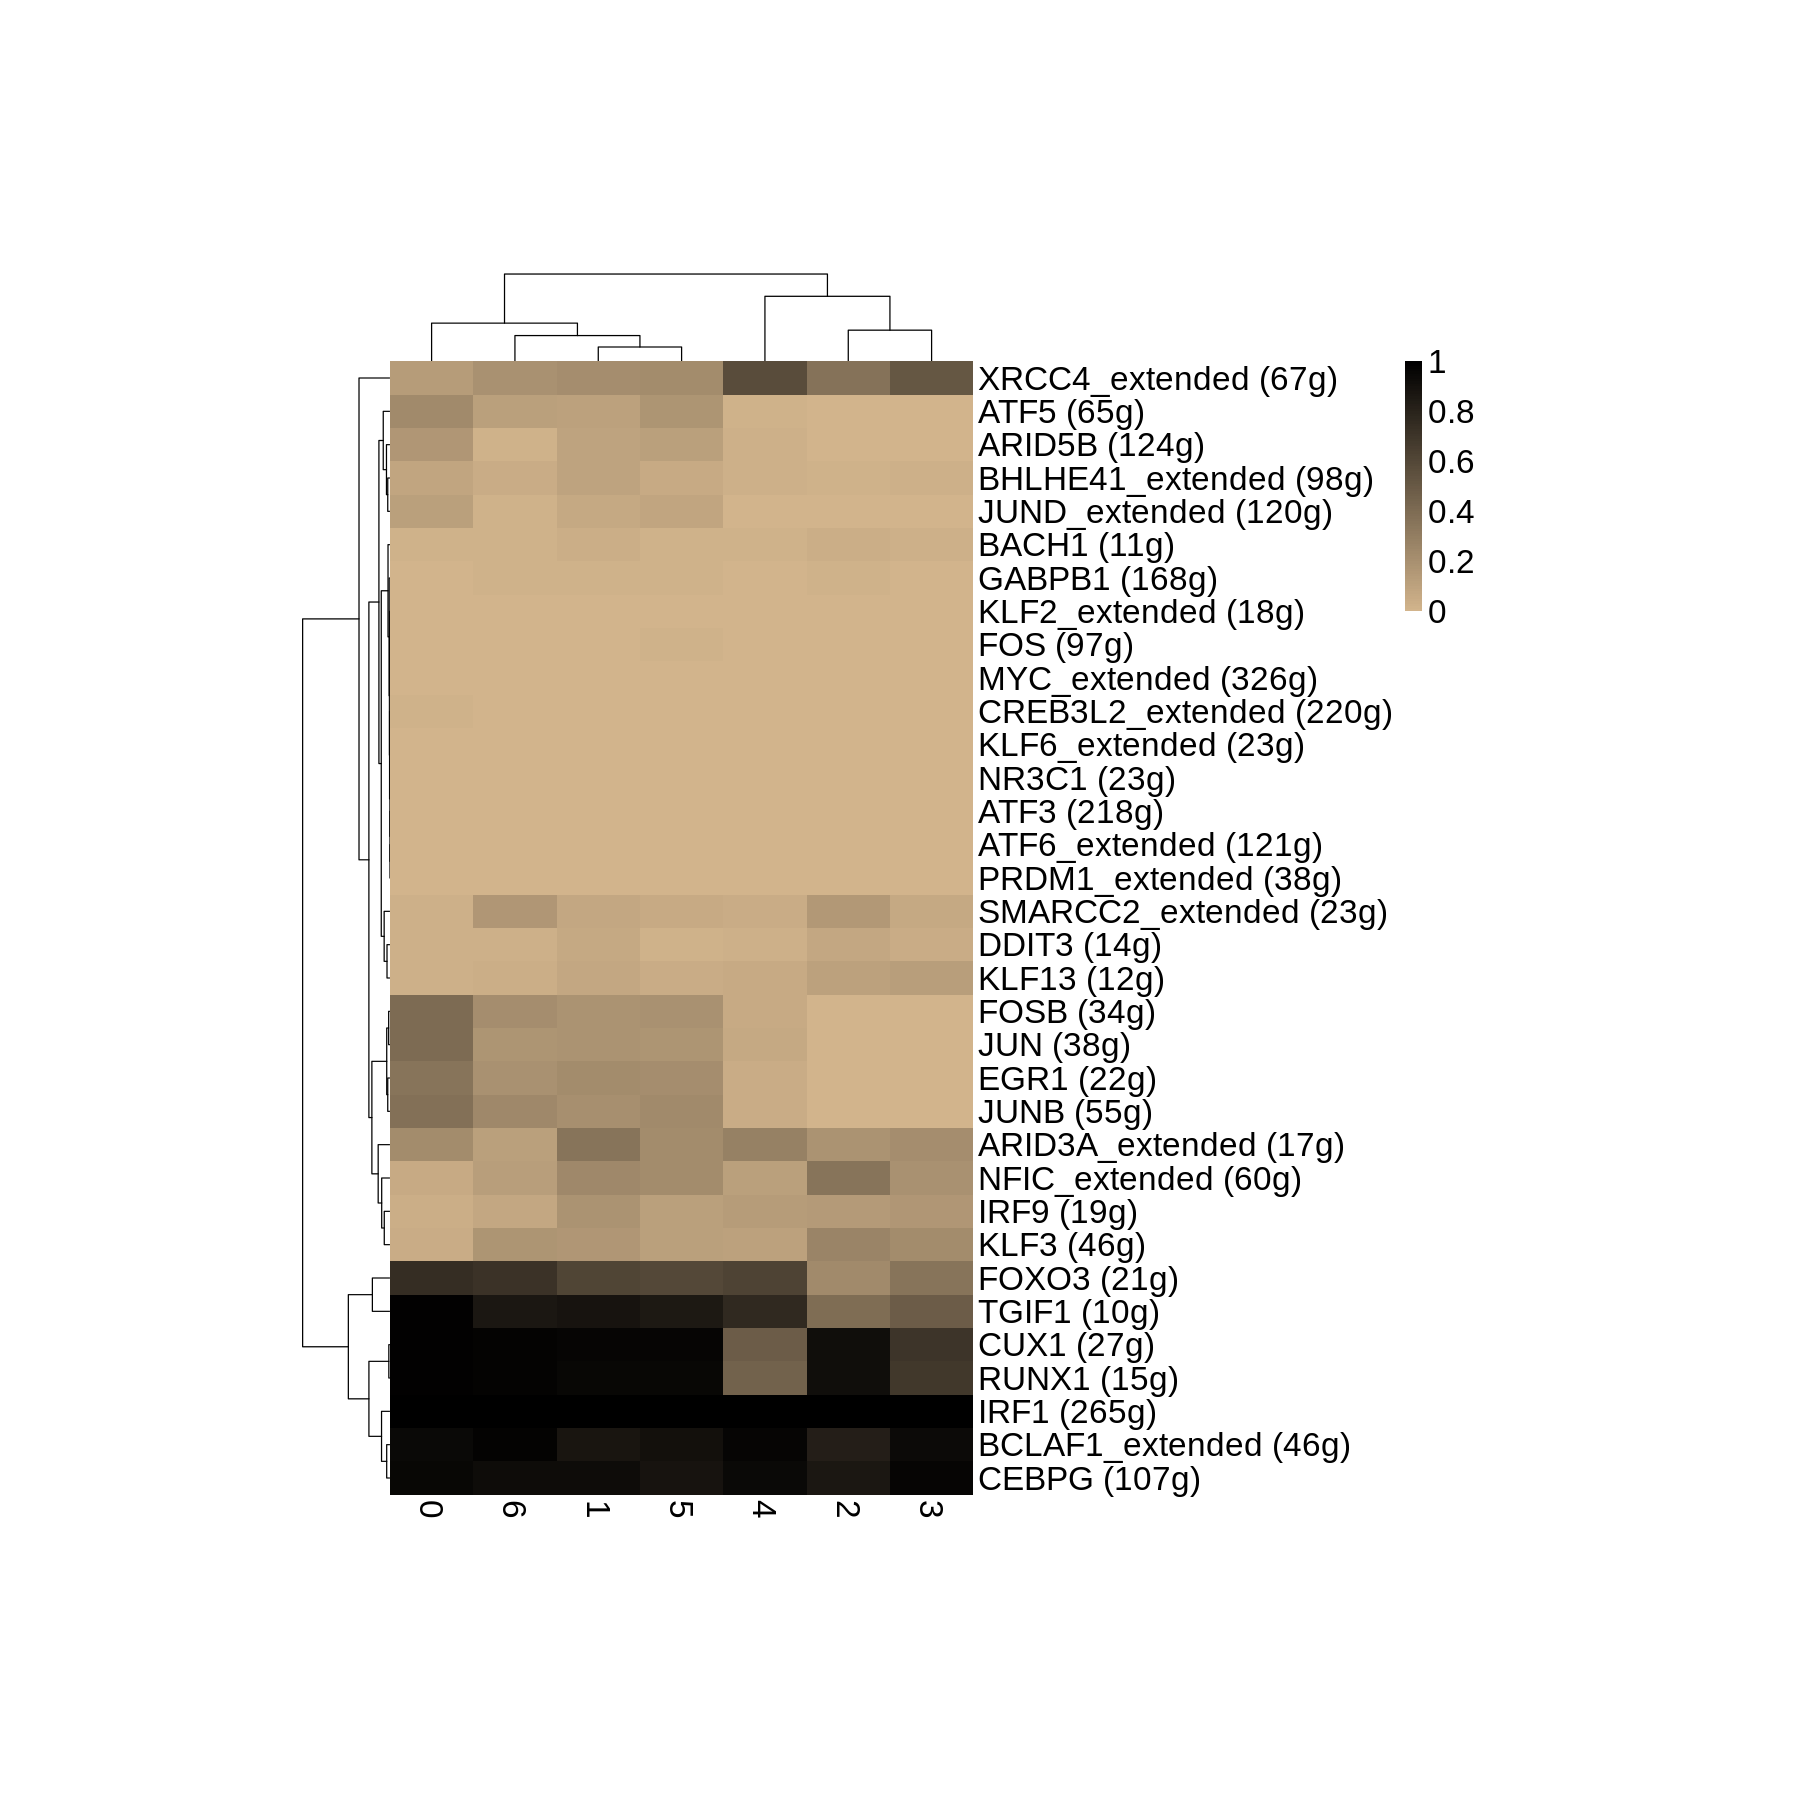

In [60]:
library(pheatmap)
pheatmap(binaryActPerc_subset ,scale="none",border=FALSE,color=colorRampPalette(c("tan","black"))(100),cellheight=20,cellwidth=50,fontsize=20)

In [61]:
topRegulators <- reshape2::melt(regulonActivity_byCellType_Binarized)
colnames(topRegulators) <- c("Regulon", "seuratCluster", "RelativeActivity")
topRegulators <- topRegulators[which(topRegulators$RelativeActivity>minPerc),]
viewTable(topRegulators)

HTML widgets cannot be represented in plain text (need html)

In [62]:
calcRSS <- function(AUC, cellAnnotation, cellTypes=NULL)
{
  if(any(is.na(cellAnnotation))) stop("NAs in annotation")
  if(any(class(AUC)=="aucellResults")) AUC <- getAUC(AUC)
  normAUC <- AUC/rowSums(AUC)
  if(is.null(cellTypes)) cellTypes <- unique(cellAnnotation)
  # 
  ctapply <- lapply
  if(require('BiocParallel')) ctapply <- bplapply
  
  rss <- ctapply(cellTypes, function(thisType)
    sapply(rownames(normAUC), function(thisRegulon)
    {
      pRegulon <- normAUC[thisRegulon,]
      pCellType <- as.numeric(cellAnnotation==thisType)
      pCellType <- pCellType/sum(pCellType)
      .calcRSS.oneRegulon(pRegulon, pCellType)
    })
  )
  rss <- do.call(cbind, rss)
  colnames(rss) <- cellTypes
  return(rss)
}

plotRSS <- function(rss, labelsToDiscard=NULL, zThreshold=1,
                    cluster_columns=FALSE, order_rows=TRUE, trh=0.01, varName="cellType",
                    col.low="grey90", col.mid="darkolivegreen3", col.high="darkgreen",
                    revCol=FALSE)
{
  varSize="RSS"
  varCol="Z"
  if(revCol) {
    varSize="Z"
    varCol="RSS"
  }
  
  rssNorm <- scale(rss) # scale the full matrix...
  rssNorm[rssNorm < zThreshold] <- 0
  rssNorm <- rssNorm[,which(!colnames(rssNorm) %in% labelsToDiscard)] # remove after calculating...
  
  ## to get topic order (easier...)
  tmp <- .plotRSS_heatmap(rssNorm, trh=trh, cluster_columns=cluster_columns, order_rows=order_rows)
  rowOrder <- rev(tmp@row_names_param$labels)
  
  ## Dotplot
  rss.df <- reshape2::melt(rss)
  head(rss.df)
  colnames(rss.df) <- c("Topic", varName, "RSS")
  rssNorm.df <- reshape2::melt(rssNorm)
  colnames(rssNorm.df) <- c("Topic", varName, "Z")
  rss.df <- merge(rss.df, rssNorm.df)
  
  rss.df <- rss.df[which(rss.df$Z >= 1.5),]
  rss.df <- rss.df[which(!rss.df[,varName] %in% labelsToDiscard),] # remove after calculating...
  # dim(rss.df)
  
  rss.df[,"Topic"] <- factor(rss.df[,"Topic"], levels=rowOrder)
  p <- dotHeatmap(rss.df, 
             var.x=varName, var.y="Topic", 
             var.size=varSize, min.size=.5, max.size=5,
             var.col=varCol, col.low=col.low, col.mid=col.mid, col.high=col.high)
  
  invisible(list(plot=p, df=rss.df, rowOrder=rowOrder))
}

#' @aliases plotRSS
#' @export 
plotRSS_oneSet <- function(rss, setName, n=5)
{
  library(ggplot2)
  library(ggrepel)
  
  rssThisType <- sort(rss[,setName], decreasing=TRUE)
  thisRss <- data.frame(regulon=names(rssThisType), rank=seq_along(rssThisType), rss=rssThisType)
  thisRss$regulon[(n+1):nrow(thisRss)] <- NA
  
  ggplot(thisRss, aes(x=rank, y=rss)) + 
    geom_point(color = "blue", size = 1) + 
    ggtitle(setName) + 
    geom_label_repel(aes(label = regulon),
                     box.padding   = 0.35, 
                     point.padding = 0.5,
                     segment.color = 'grey50',
                     na.rm=TRUE) +
    theme_classic()
}



## Internal functions:
.H <- function(pVect){
  pVect <- pVect[pVect>0] # /sum(pVect) ??
  - sum(pVect * log2(pVect))
}

# Jensen-Shannon Divergence (JSD)
calcJSD <- function(pRegulon, pCellType)
{
  (.H((pRegulon+pCellType)/2)) - ((.H(pRegulon)+.H(pCellType))/2)
}

# Regulon specificity score (RSS)
.calcRSS.oneRegulon <- function(pRegulon, pCellType)
{
  jsd <- calcJSD(pRegulon, pCellType)
  1 - sqrt(jsd)
}

.plotRSS_heatmap <- plotRSS_heatmap <- function(rss, trh=NULL, row_names_gp=gpar(fontsize=5), order_rows=TRUE, cluster_rows=FALSE, name="RSS", ...)
{
  if(is.null(trh)) trh <- signif(quantile(rss, p=.97),2)
  
  library(ComplexHeatmap)
  rssSubset <- rss[rowSums(rss > trh)>0,]
  rssSubset <- rssSubset[,colSums(rssSubset > trh)>0]
  message("Showing regulons and cell types with any RSS > ", trh, " (dim: ", nrow(rssSubset), "x", ncol(rssSubset),")")
  
  if(order_rows)
  {
    maxVal <- apply(rssSubset, 1, which.max)
    rss_ordered <- rssSubset[0,]
    for(i in 1:ncol(rssSubset))
    {
      tmp <- rssSubset[which(maxVal==i),,drop=F]
      tmp <- tmp[order(tmp[,i], decreasing=FALSE),,drop=F]
      rss_ordered <- rbind(rss_ordered, tmp)
    }
    rssSubset <- rss_ordered
    cluster_rows=FALSE
  }
  
  Heatmap(rssSubset, name=name, row_names_gp=row_names_gp, cluster_rows=cluster_rows, ...)
} 

In [63]:
cellClusters<-data.frame(rownames(allPC3@meta.data),allPC3@meta.data$seurat_clusters)

In [64]:
rownames(cellClusters)<-cellClusters[,1]
cellClusters[,1]<-NULL

In [65]:
rss <- calcRSS(AUC=getAUC(regulonAUC), cellAnnotation=cellClusters[colnames(regulonAUC), ])

Loading required package: BiocParallel



In [66]:
rss

0          2          1          4           6          
RUNX1 (15g)            0.46053775 0.14609398 0.22205830 0.079111537 0.018969043
CUX1 (27g)             0.45641518 0.14932478 0.22464500 0.079340929 0.018767146
BACH1 (11g)            0.02987964 0.03492825 0.04060055 0.007724956 0.002035068
DDIT3 (14g)            0.04565923 0.06804513 0.07152148 0.016358097 0.005085176
KLF13 (12g)            0.04908744 0.09032107 0.07683072 0.035737517 0.009253346
ARID3A_extended (17g)  0.29476108 0.08912347 0.21884946 0.076820328 0.010975924
NFIC_extended (60g)    0.06838580 0.18627342 0.17986885 0.034685839 0.010797672
KLF3 (46g)             0.05986219 0.16228381 0.12759892 0.041292008 0.020584534
XRCC4_extended (67g)   0.17916870 0.15819691 0.14053386 0.131718513 0.014444052
SMARCC2_extended (23g) 0.04118172 0.12616555 0.08626651 0.024695059 0.031907383
CEBPG (107g)           0.42489863 0.13806663 0.21796504 0.078757088 0.017427897
BCLAF1_extended (46g)  0.43859242 0.12347212 0.19713057 0.084265096 0.019479725
XBP1 (55g)             0.45878714 0.13660830 0.21221565 0.089618757 0.019258816
KLF6_extended (23g)    0.45492755 0.11817201 0.21443045 0.072284740 0.019266850
KLF2_extended (18g)    0.42967372 0.12508919 0.21803977 0.080681048 0.017981905
IRF9 (19g)             0.04771728 0.09566443 0.15406519 0.049486830 0.010046889
GABPB1 (168g)          0.42550505 0.12091644 0.22588901 0.074999675 0.019487318
BHLHE41_extended (98g) 0.43414896 0.09108665 0.22458276 0.064809577 0.017657268
ATF3 (218g)            0.48157028 0.09285940 0.22700760 0.074180556 0.017891127
STAT1 (256g)           0.48769672 0.12593268 0.21356354 0.076457708 0.019334533
IRF4 (297g)            0.47535032 0.13164212 0.21840692 0.081714256 0.019868331
IRF1 (265g)            0.46989195 0.13046463 0.22218442 0.082265272 0.019159423
BCL11A_extended (272g) 0.47561046 0.11692002 0.22848093 0.078298582 0.019737204
PRDM1_extended (38g)   0.46851904 0.10811782 0.21556861 0.081866309 0.017796632
FOS (97g)              0.48771286 0.11405056 0.22041286 0.076892014 0.019538929
IRF7 (112g)            0.47884558 0.10710657 0.22482652 0.075990190 0.018577602
FOXO3 (21g)            0.44515355 0.04389954 0.18674391 0.070712600 0.020487433
JUND (38g)             0.49524100 0.07833866 0.22331402 0.072747240 0.017691837
CEBPB (196g)           0.49443695 0.10649016 0.22030860 0.078502845 0.017735838
EGR1 (22g)             0.52905177 0.05080549 0.21436725 0.058090545 0.017709284
JUNB (55g)             0.53128311 0.05751568 0.22006969 0.064917745 0.017677669
MYC_extended (326g)    0.49695454 0.10574199 0.22359169 0.073615657 0.019418534
CREB3L2 (57g)          0.48313457 0.10785703 0.21127492 0.073398054 0.018622546
TGIF1 (10g)            0.54982383 0.04141918 0.19746132 0.052139470 0.019873559
JUN (38g)              0.52876693 0.06860931 0.21678453 0.071218201 0.017438640
FOSB (34g)             0.52953400 0.06847650 0.21628699 0.070646910 0.017584643
ARID5B (124g)          0.50231595 0.09845031 0.22094262 0.075470469 0.017882857
ATF5 (65g)             0.52144412 0.07501846 0.21610027 0.072668051 0.017902277
ATF6_extended (121g)   0.47852471 0.12062485 0.21201766 0.077452428 0.020763154
NR3C1 (23g)            0.44129219 0.10793456 0.22322910 0.074753794 0.018988356
RELB (69g)             0.47701398 0.13477021 0.21009658 0.074470421 0.019837888
                       5           3         
RUNX1 (15g)            0.063766184 0.07148228
CUX1 (27g)             0.063871426 0.07178885
BACH1 (11g)            0.007009612 0.01637402
DDIT3 (14g)            0.012053715 0.03033627
KLF13 (12g)            0.024224354 0.06532032
ARID3A_extended (17g)  0.048452348 0.05247577
NFIC_extended (60g)    0.062586109 0.05760908
KLF3 (46g)             0.035812380 0.07901771
XRCC4_extended (67g)   0.051449094 0.11193005
SMARCC2_extended (23g) 0.028675804 0.03758245
CEBPG (107g)           0.054675254 0.07774676
BCLAF1_extended (46g)  0.056178873 0.08221075
XBP1 (55g)             0.063125779 0.07280731
KLF6_extended (23g)

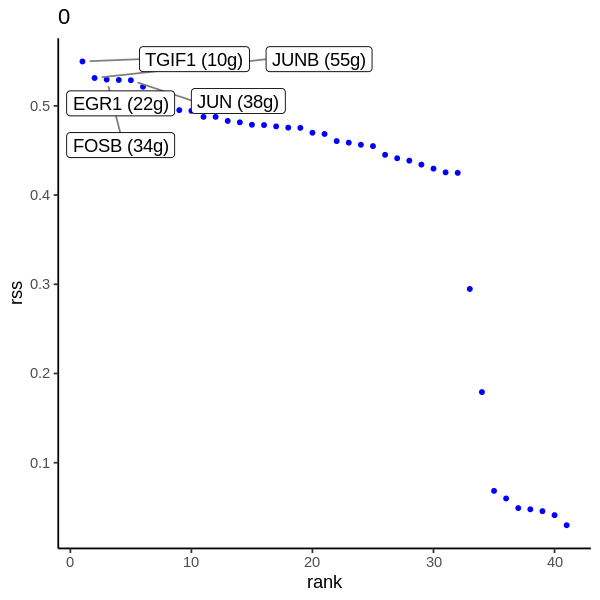

In [67]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "0") # cluster ID

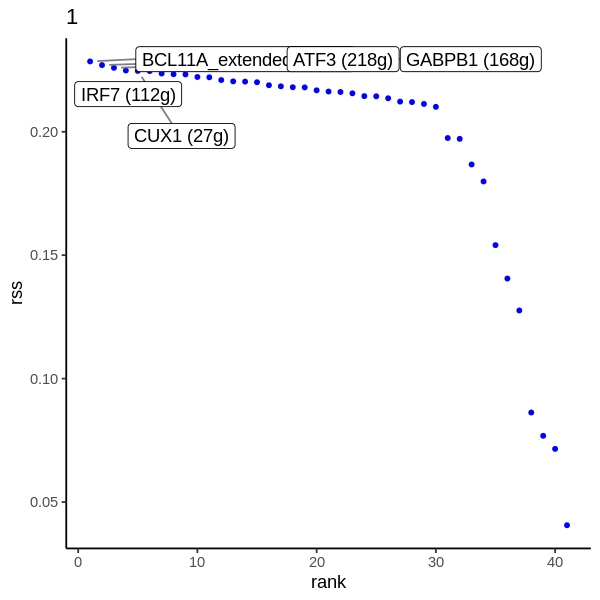

In [68]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "1") # cluster ID

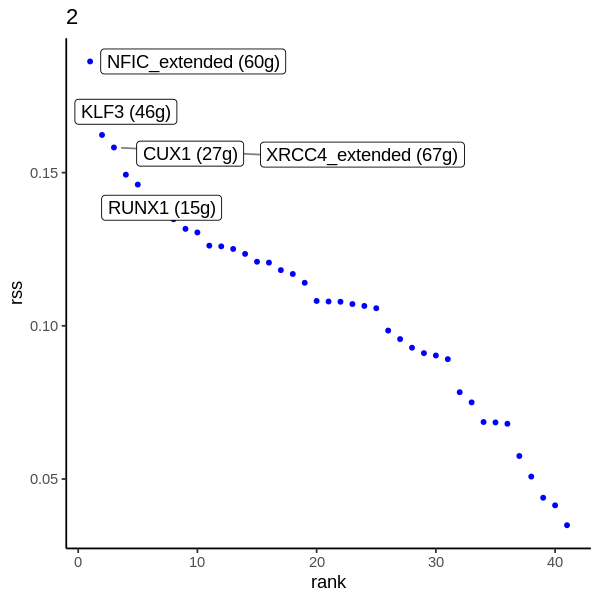

In [69]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "2") # cluster ID

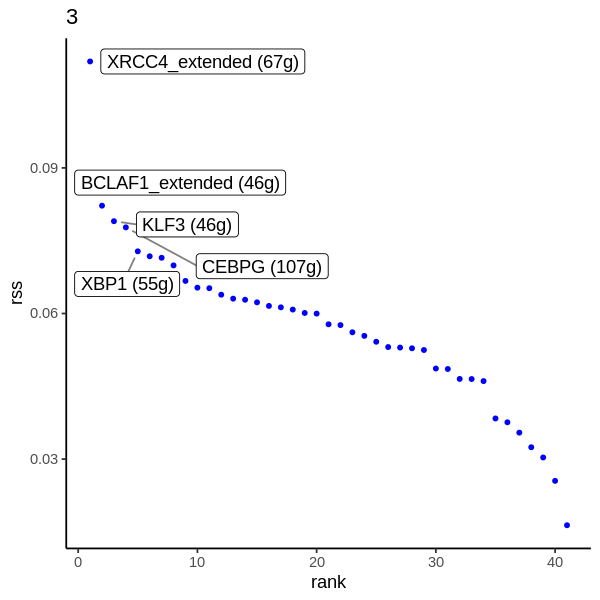

In [70]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "3") # cluster ID

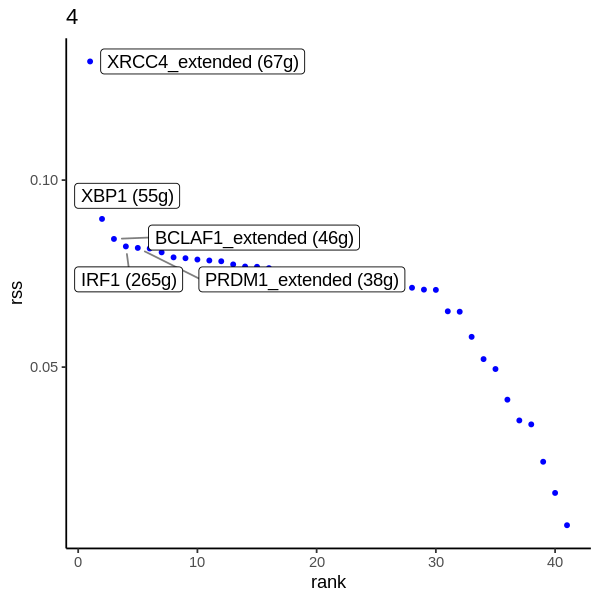

In [71]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "4") # cluster ID

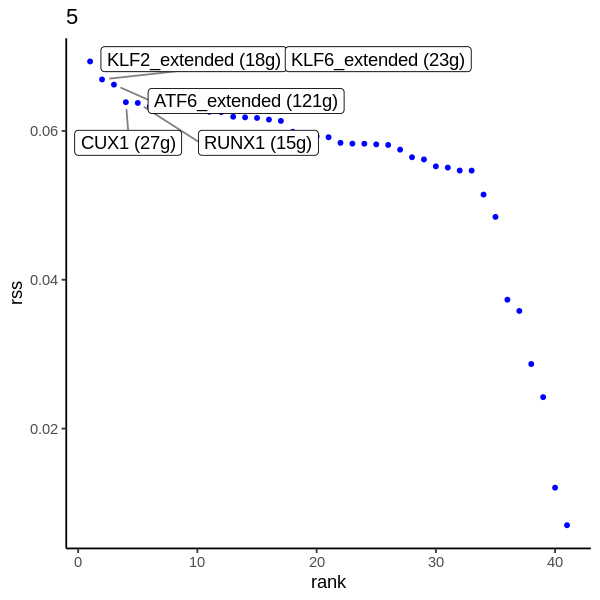

In [72]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "5") # cluster ID

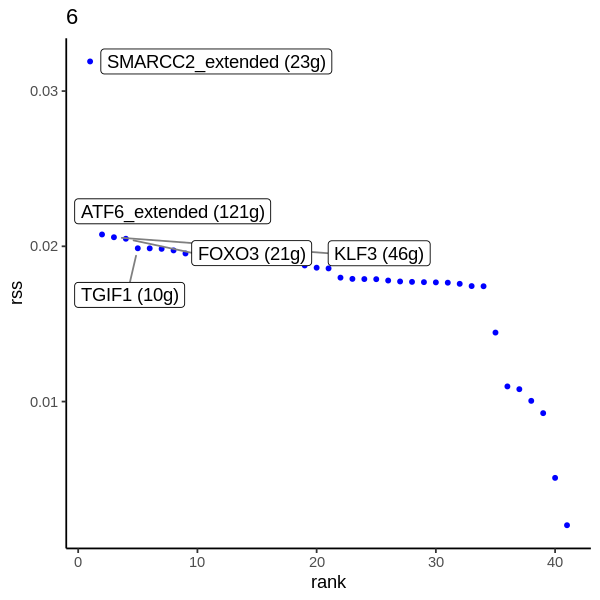

In [73]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "6") # cluster ID

In [74]:
##导入原始regulonAUC矩阵
AUCmatrix <- readRDS("int/3.4_regulonAUC.Rds")
AUCmatrix <- AUCmatrix@assays@data@listData$AUC
AUCmatrix <- data.frame(t(AUCmatrix), check.names=F)
RegulonName_AUC <- colnames(AUCmatrix)
RegulonName_AUC <- gsub(' \\(','_',RegulonName_AUC)
RegulonName_AUC <- gsub('\\)','',RegulonName_AUC)
colnames(AUCmatrix) <- RegulonName_AUC

In [75]:
scRNAauc <- AddMetaData(allPC3, AUCmatrix)
saveRDS(scRNAauc,'scRNAauc.rds')

In [76]:
##导入二进制regulonAUC矩阵
BINmatrix <- readRDS("int/4.1_binaryRegulonActivity.Rds")
BINmatrix <- data.frame(t(BINmatrix), check.names=F)
RegulonName_BIN <- colnames(BINmatrix)
RegulonName_BIN <- gsub(' \\(','_',RegulonName_BIN)
RegulonName_BIN <- gsub('\\)','',RegulonName_BIN)
colnames(BINmatrix) <- RegulonName_BIN

In [77]:
scRNAbin <- AddMetaData(allPC3, BINmatrix)
saveRDS(scRNAbin, 'scRNAbin.rds')

In [78]:
scRNA<-allPC3

In [79]:
scRNAauc<-readRDS('scRNAauc.rds')

In [80]:
scRNAbin<-readRDS('scRNAbin.rds')

In [81]:
library('RColorBrewer')

In [84]:
colnames(scRNAauc@meta.data)

[1] "orig.ident"             "nCount_RNA"             "nFeature_RNA"          
 [4] "percent.mt"             "percent.ig"             "integrated_snn_res.0.1"
 [7] "integrated_snn_res.0.2" "integrated_snn_res.0.3" "integrated_snn_res.0.4"
[10] "integrated_snn_res.0.5" "integrated_snn_res.0.6" "integrated_snn_res.0.7"
[13] "integrated_snn_res.0.8" "integrated_snn_res.0.9" "integrated_snn_res.1"  
[16] "seurat_clusters"        "RUNX1_extended_19g"     "RUNX1_15g"             
[19] "CUX1_extended_55g"      "CUX1_27g"               "BACH1_11g"             
[22] "DDIT3_extended_46g"     "DDIT3_14g"              "KLF13_extended_32g"    
[25] "ARID3A_extended_17g"    "NFIC_extended_60g"      "KLF13_12g"             
[28] "KLF3_extended_142g"     "KLF3_46g"               "XRCC4_extended_67g"    
[31] "SMARCC2_extended_23g"   "CEBPG_extended_189g"    "CEBPG_107g"            
[34] "BCLAF1_extended_46g"    "XBP1_extended_149g"     "XBP1_55g"              
[37] "KLF6_extended_23g"      "KLF2_extended_18g"      "IRF9_extended_24g"     
[40] "IRF9_19g"               "GABPB1_extended_239g"   "GABPB1_168g"           
[43] "BHLHE41_extended_98g"   "ATF3_extended_319g"     "ATF3_218g"             
[46] "STAT1_extended_404g"    "STAT1_256g"             "IRF4_297g"             
[49] "IRF1_265g"              "BCL11A_extended_272g"   "IRF1_extended_482g"    
[52] "IRF4_extended_447g"     "PRDM1_extended_38g"     "FOS_97g"               
[55] "IRF7_extended_227g"     "IRF7_112g"              "FOXO3_extended_121g"   
[58] "JUND_38g"               "CEBPB_extended_253g"    "CEBPB_196g"            
[61] "BACH1_extended_109g"    "EGR1_22g"               "JUNB_55g"              
[64] "EGR1_extended_34g"      "FOS_extended_292g"      "MYC_extended_326g"     
[67] "CREB3L2_extended_220g"  "TGIF1_10g"              "JUN_extended_206g"     
[70] "JUND_extended_120g"     "JUNB_extended_165g"     "FOSB_extended_136g"    
[73] "JUN_38g"                "FOSB_34g"               "ARID5B_124g"           
[76] "ATF5_extended_146g"     "ATF5_65g"               "ATF6_extended_121g"    
[79] "CREB3L2_57g"            "FOXO3_21g"              "NR3C1_extended_33g"    
[82] "NR3C1_23g"              "RELB_extended_101g"     "RELB_69g"

In [85]:
colnames(scRNAbin@meta.data)

[1] "orig.ident"             "nCount_RNA"             "nFeature_RNA"          
 [4] "percent.mt"             "percent.ig"             "integrated_snn_res.0.1"
 [7] "integrated_snn_res.0.2" "integrated_snn_res.0.3" "integrated_snn_res.0.4"
[10] "integrated_snn_res.0.5" "integrated_snn_res.0.6" "integrated_snn_res.0.7"
[13] "integrated_snn_res.0.8" "integrated_snn_res.0.9" "integrated_snn_res.1"  
[16] "seurat_clusters"        "ARID3A_extended_17g"    "ARID5B_124g"           
[19] "ATF3_218g"              "ATF5_65g"               "ATF5_extended_146g"    
[22] "ATF6_extended_121g"     "BACH1_11g"              "BACH1_extended_109g"   
[25] "BCLAF1_extended_46g"    "BHLHE41_extended_98g"   "CEBPG_107g"            
[28] "CEBPG_extended_189g"    "CREB3L2_extended_220g"  "CUX1_27g"              
[31] "CUX1_extended_55g"      "DDIT3_14g"              "DDIT3_extended_46g"    
[34] "EGR1_22g"               "EGR1_extended_34g"      "FOS_97g"               
[37] "FOSB_34g"               "FOSB_extended_136g"     "FOXO3_21g"             
[40] "FOXO3_extended_121g"    "GABPB1_168g"            "GABPB1_extended_239g"  
[43] "IRF1_265g"              "IRF9_19g"               "IRF9_extended_24g"     
[46] "JUN_38g"                "JUNB_55g"               "JUNB_extended_165g"    
[49] "JUND_extended_120g"     "KLF13_12g"              "KLF13_extended_32g"    
[52] "KLF2_extended_18g"      "KLF3_46g"               "KLF3_extended_142g"    
[55] "KLF6_extended_23g"      "MYC_extended_326g"      "NFIC_extended_60g"     
[58] "NR3C1_23g"              "PRDM1_extended_38g"     "RUNX1_15g"             
[61] "RUNX1_extended_19g"     "SMARCC2_extended_23g"   "TGIF1_10g"             
[64] "XRCC4_extended_67g"

In [86]:
options(repr.plot.width=4, repr.plot.height=12)

In [87]:
#dir.create('scenic_seurat')
#FeaturePlot
p1 = FeaturePlot(scRNAauc, features='FOS_97g', label=T, reduction = 'umap',cols=c('dodgerblue','tomato'))
p3=FeaturePlot(scRNA,reduction='umap',label=T,features=c('FOS'),cols=rev(brewer.pal(4,'Spectral')))

In [88]:
p2 = VlnPlot(scRNAauc, features = 'FOS_97g', pt.size = 0, group.by="seurat_clusters") 

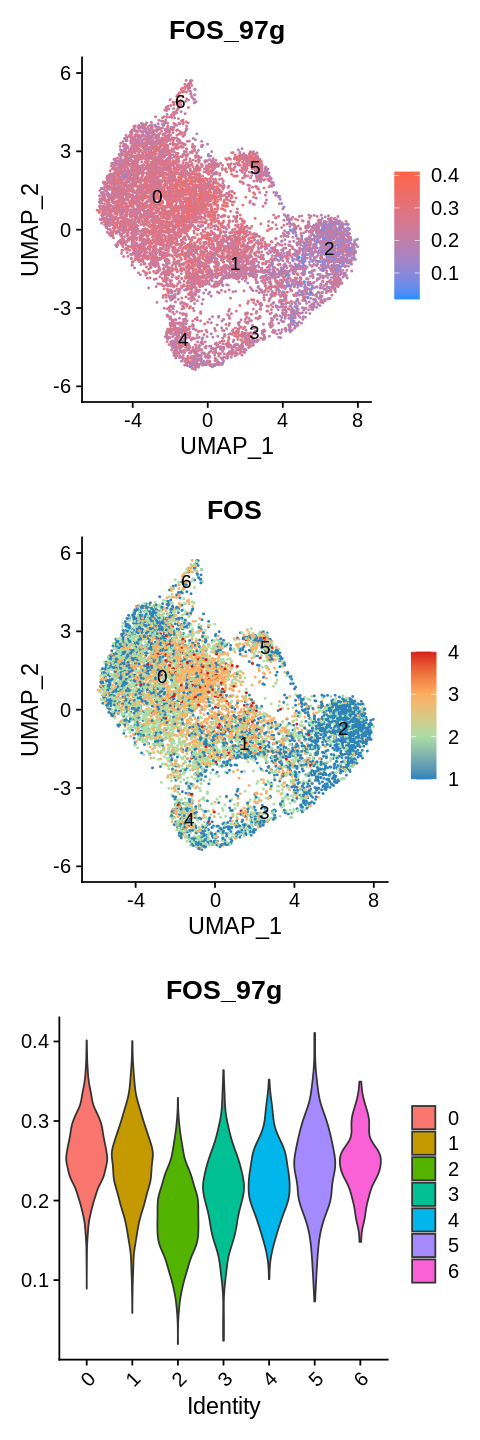

In [89]:
plot_grid(p1,p3,p2,ncol=1,nrow=3)

In [90]:
#dir.create('scenic_seurat')
#FeaturePlot
p1 = FeaturePlot(scRNAauc, features='EGR1_22g', label=T, reduction = 'umap',cols=c('dodgerblue','tomato'))
p3=FeaturePlot(scRNA,reduction='umap',label=T,features=c('EGR1'),cols=rev(brewer.pal(4,'Spectral')))

In [91]:
p2 = VlnPlot(scRNAauc, features = 'EGR1_22g', pt.size = 0, group.by="seurat_clusters") 

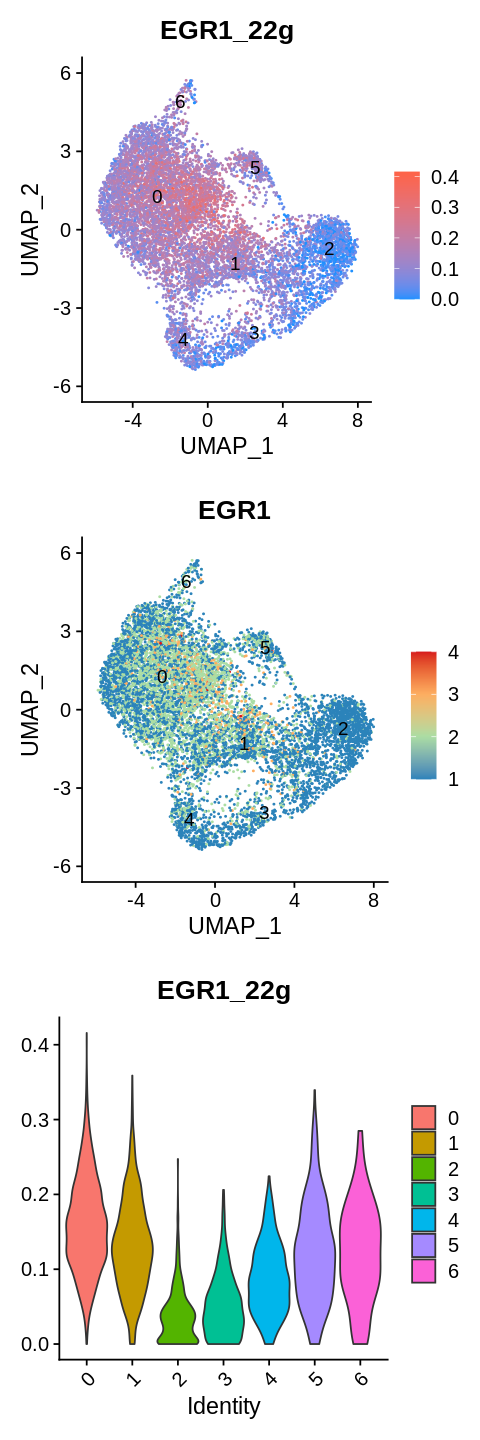

In [92]:
plot_grid(p1,p3,p2,ncol=1,nrow=3)

In [94]:
library(pheatmap)
cellInfo <- readRDS("int/cellInfo.Rds")
celltype = subset(cellInfo,select = 'seuratCluster')
AUCmatrix <- t(AUCmatrix)
BINmatrix <- t(BINmatrix)
#挑选部分感兴趣的regulons
#my.regulons <- c()
#myAUCmatrix <- AUCmatrix[rownames(AUCmatrix)%in%my.regulons,]
#myBINmatrix <- BINmatrix[rownames(BINmatrix)%in%my.regulons,]
#使用regulon原始AUC值绘制热图

In [99]:
myregulon<-c('FOSB_18g','JUNB_19g','JUN_39g','TGIF1_extended_28g','EGR1_16g','JUND_94g','KLF2_extended_98g','SMAD1_45g','FOXO3_92g','XBP1_extended_227g','POU2F2_22g','NFIC_extended_43g','DDIT3_71g','IRF9_48g','XRCC4_extended_91g','BCLAF1_extended_10g','CEBPG_53g')

In [100]:
myAUCmatrix<-AUCmatrix[myregulon,]

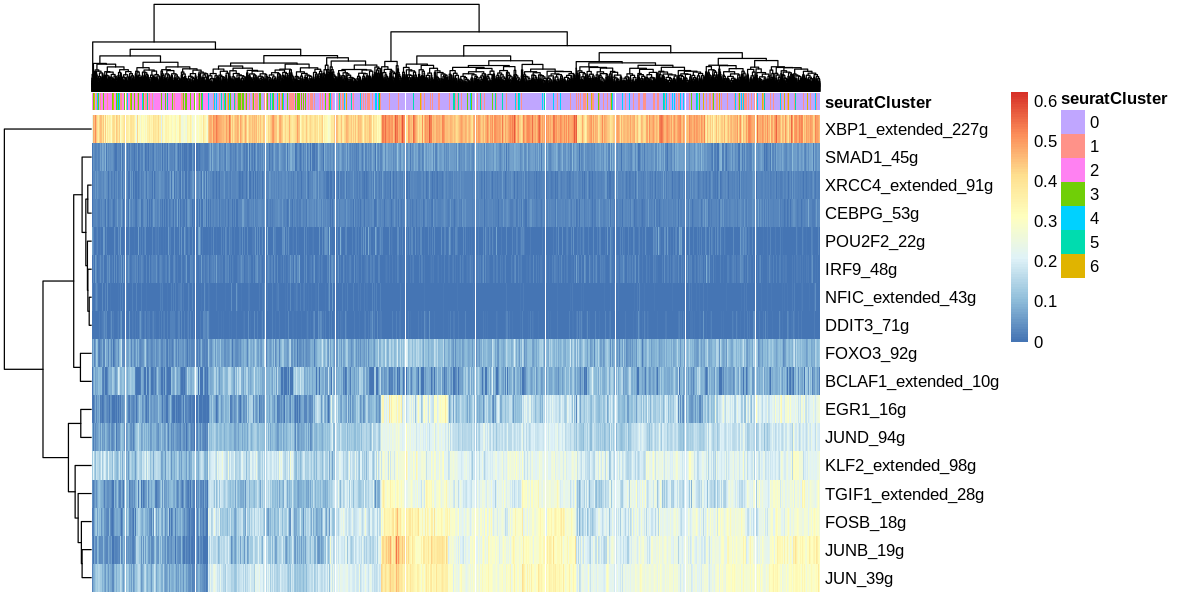

In [101]:
pheatmap(myAUCmatrix, show_colnames=F, annotation_col=celltype)

In [102]:
myBINmatrix<-BINmatrix[myregulon,]

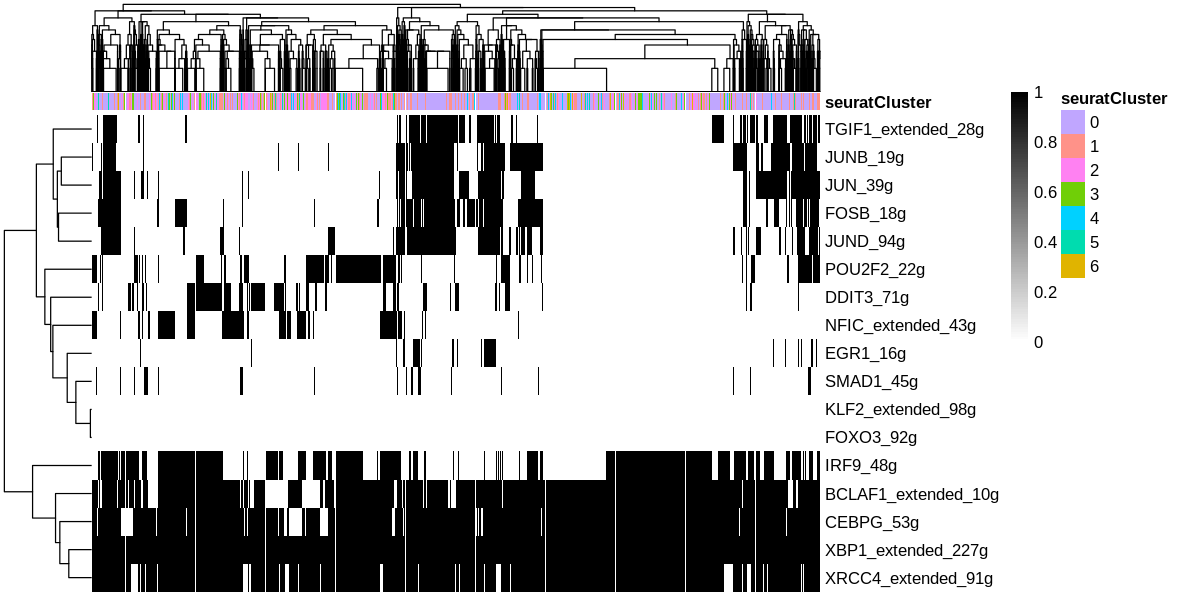

In [103]:
#使用regulon二进制AUC值绘制热图
pheatmap(myBINmatrix, show_colnames=F, annotation_col=celltype,color = colorRampPalette(colors = c("white","black"))(100))

In [109]:
myregulon<-c('FOSB_18g','JUNB_19g','JUN_39g','TGIF1_extended_28g','EGR1_16g','JUND_94g','SMAD1_45g','POU2F2_22g','NFIC_extended_43g','DDIT3_71g')

In [110]:
myAUCmatrix<-AUCmatrix[myregulon,]

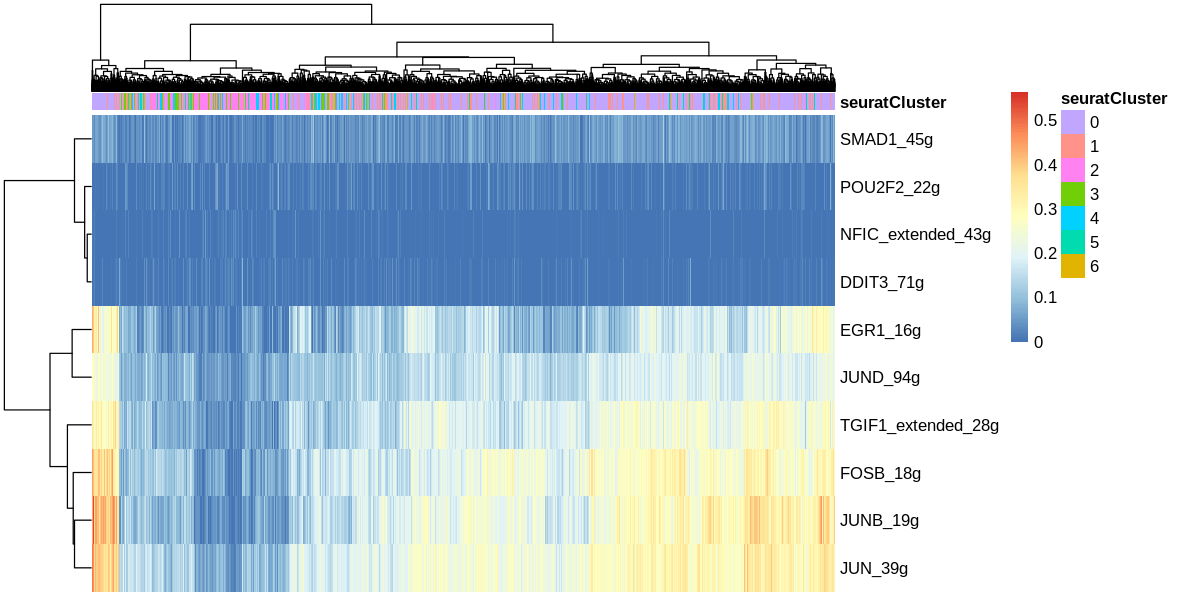

In [111]:
pheatmap(myAUCmatrix, show_colnames=F, annotation_col=celltype)

In [112]:
myBINmatrix<-BINmatrix[myregulon,]

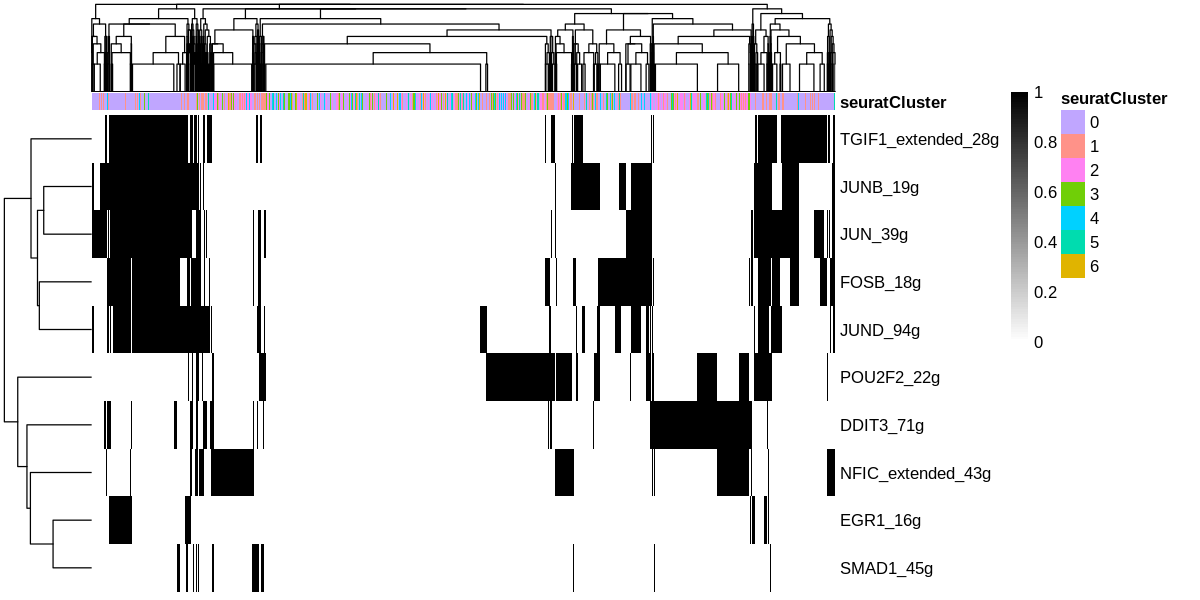

In [113]:
#使用regulon二进制AUC值绘制热图
pheatmap(myBINmatrix, show_colnames=F, annotation_col=celltype,color = colorRampPalette(colors = c("white","black"))(100))